# Allocazione Dinamica delle Strategie - Momentum Strategy

## Obiettivo
Implementare un sistema di allocazione dinamica che:
- **Favorisce** le strategie che stanno performando bene
- **Penalizza** quelle che stanno performando male  
- **Ribilancia** ogni lunedì
- Testa diverse combinazioni per trovare l'allocazione ottimale

## Metodologie da Esplorare
1. **Momentum Puro**: Allocazione basata su performance recente
2. **Risk-Adjusted Momentum**: Momentum aggiustato per il rischio
3. **Momentum con Volatility Scaling**: Allocazione che considera la volatilità
4. **Momentum Ranking**: Top N strategie ricevono più capitale
5. **Momentum Smooth**: Transizioni graduali per ridurre il turnover

## Metriche di Valutazione
- Sharpe Ratio del portafoglio
- Maximum Drawdown
- Calmar Ratio  
- Turnover del portafoglio
- Stabilità delle allocazioni

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from pathlib import Path
import glob
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("🚀 Librerie importate con successo!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 Numpy version: {np.__version__}")

🚀 Librerie importate con successo!
📊 Pandas version: 2.3.0
🔢 Numpy version: 2.2.6


## 1. Caricamento e Esplorazione dei Dati

Prima di implementare l'allocazione dinamica, esploriamo tutti i dati disponibili per capire:
- Quante strategie abbiamo
- I loro timeframe e parametri
- La frequenza di aggiornamento
- Le performance storiche

In [3]:
# Definizione del percorso base e ricerca automatica dei file
data_path = Path('/workspaces/bollingerBands/notebooks/DATA')

def load_strategy_data(file_path, strategy_name):
    """
    Carica e processa i dati di una strategia con gestione encoding
    """
    # Lista degli encoding da provare
    encodings = ['utf-8', 'utf-16', 'latin-1', 'cp1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            # Prova a caricare con encoding specifico
            df = pd.read_csv(file_path, sep='\t', encoding=encoding)
            
            # Rinomina le colonne per standardizzazione
            df.columns = ['datetime', 'balance', 'equity', 'deposit_load']
            
            # Converte datetime
            df['datetime'] = pd.to_datetime(df['datetime'], format='%Y.%m.%d %H:%M')
            
            # ⚠️ FILTRO TEMPORALE: Solo dal 2024 in poi per sincronizzazione
            df = df[df['datetime'] >= '2024-01-01'].copy()
            
            if len(df) == 0:
                print(f"⚠️ {strategy_name}: Nessun dato dal 2024 in poi")
                return None
            
            # Aggiungi informazioni strategia
            df['strategy'] = strategy_name
            
            # Calcola rendimenti
            df['returns'] = df['balance'].pct_change()
            df['cumulative_returns'] = (1 + df['returns']).cumprod() - 1
            
            # Aggiungi informazioni giorno della settimana
            df['weekday'] = df['datetime'].dt.dayofweek  # 0=Lunedì
            df['week'] = df['datetime'].dt.isocalendar().week
            df['year'] = df['datetime'].dt.year
            
            print(f"✅ {strategy_name}: {len(df)} records dal 2024, da {df['datetime'].min()} a {df['datetime'].max()}")
            
            return df
            
        except UnicodeDecodeError:
            continue
        except Exception as e:
            if encoding == encodings[-1]:  # Ultimo tentativo
                print(f"❌ Errore caricando {strategy_name}: {e}")
                return None
            continue
    
    print(f"❌ Impossibile decodificare {strategy_name} con nessun encoding")
    return None

# Ricerca automatica dei file di strategia
strategy_files = {}
for pair_folder in data_path.iterdir():
    if pair_folder.is_dir():
        pair_name = pair_folder.name.upper()
        
        # Cerca tutti i file CSV nella cartella
        csv_files = list(pair_folder.glob('*.csv'))
        
        for csv_file in csv_files:
            # Estrai informazioni dal nome file
            filename = csv_file.stem
            parts = filename.split('_')
            
            if len(parts) >= 3:
                timeframe = parts[1]
                params = parts[2]
                
                strategy_name = f"{pair_name}_{timeframe}_{params}"
                strategy_files[strategy_name] = csv_file

print(f"🔍 Trovate {len(strategy_files)} strategie:")
for name, path in strategy_files.items():
    print(f"  📊 {name}: {path.name}")

🔍 Trovate 12 strategie:
  📊 USDCAD_1m_1440,1: usdcad_1m_1440,1.csv
  📊 USDCAD_15m_1440,0.1: usdcad_15m_1440,0.1.csv
  📊 USDCAD_5m_120,2: usdcad_5m_120,2.csv
  📊 USDCAD_1m_120,2: usdcad_1m_120,2.csv
  📊 USDCAD_1m_7200,0.5: usdcad_1m_7200,0.5.csv
  📊 USDCAD_5m_1440,0.5: usdcad_5m_1440,0.5.csv
  📊 EURCHF_1m_120,2: eurchf_1m_120,2.csv
  📊 EURCHF_1m_7200,0.5: eurchf_1m_7200,0.5.csv
  📊 EURCHF_1m_1440,1: eurchf_1m_1440,1.csv
  📊 EURCHF_5m_120,2: eurchf_5m_120,2.csv
  📊 EURCHF_5m_1440,0.5: eurchf_5m_1440,0.5.csv
  📊 EURCHF_15m_1440,0.1: eurchf_15m_1440,0.1.csv


In [4]:
# Carica tutte le strategie
all_strategies = {}
strategy_dataframes = []

for strategy_name, file_path in strategy_files.items():
    df = load_strategy_data(file_path, strategy_name)
    if df is not None:
        all_strategies[strategy_name] = df
        strategy_dataframes.append(df)

print(f"\n🎯 Caricate con successo {len(all_strategies)} strategie")

# Concatena tutti i dati per l'analisi
if strategy_dataframes:
    combined_data = pd.concat(strategy_dataframes, ignore_index=True)
    print(f"📈 Dataset combinato: {len(combined_data)} records totali")
    print(f"📅 Periodo: da {combined_data['datetime'].min()} a {combined_data['datetime'].max()}")
    
    # Statistiche per strategia
    print("\n📊 Statistiche per strategia:")
    for strategy_name, df in all_strategies.items():
        returns_mean = df['returns'].mean() * 100
        returns_std = df['returns'].std() * 100
        total_return = ((df['balance'].iloc[-1] / df['balance'].iloc[0]) - 1) * 100
        print(f"  🔸 {strategy_name}: "
              f"Rendimento totale: {total_return:.2f}%, "
              f"Media giornaliera: {returns_mean:.4f}%, "
              f"Volatilità: {returns_std:.4f}%")

✅ USDCAD_1m_1440,1: 2859 records dal 2024, da 2024-01-01 00:00:00 a 2025-07-04 23:58:00
✅ USDCAD_15m_1440,0.1: 836 records dal 2024, da 2024-01-01 00:00:00 a 2025-07-04 23:58:00
✅ USDCAD_5m_120,2: 3043 records dal 2024, da 2024-01-01 00:00:00 a 2025-07-04 23:58:00
✅ USDCAD_1m_120,2: 14497 records dal 2024, da 2024-01-01 00:00:00 a 2025-07-04 23:58:00
✅ USDCAD_1m_7200,0.5: 1137 records dal 2024, da 2024-01-01 00:00:00 a 2025-07-04 23:58:00
✅ USDCAD_5m_1440,0.5: 986 records dal 2024, da 2024-01-01 00:00:00 a 2025-07-04 23:58:00
✅ EURCHF_1m_120,2: 13818 records dal 2024, da 2024-01-02 00:59:00 a 2025-07-04 23:58:00
✅ EURCHF_1m_7200,0.5: 1340 records dal 2024, da 2024-01-03 13:41:00 a 2025-07-04 23:58:00
✅ EURCHF_1m_1440,1: 3040 records dal 2024, da 2024-01-02 12:22:00 a 2025-07-04 23:58:00
✅ EURCHF_5m_120,2: 3058 records dal 2024, da 2024-01-02 04:57:00 a 2025-07-04 23:58:00
✅ EURCHF_5m_1440,0.5: 1155 records dal 2024, da 2024-01-03 13:41:00 a 2025-07-04 23:58:00
✅ EURCHF_15m_1440,0.1: 11

In [5]:
# Analisi dettagliata delle date per verifica sincronizzazione
if all_strategies:
    print("\n🔍 ANALISI TEMPORALE DETTAGLIATA (Post-2024)")
    print("=" * 70)
    
    for strategy_name, df in all_strategies.items():
        start_date = df['datetime'].min()
        end_date = df['datetime'].max()
        total_records = len(df)
        
        # Conta records per anno
        records_2024 = len(df[df['datetime'].dt.year == 2024])
        records_2025 = len(df[df['datetime'].dt.year == 2025]) if df['datetime'].dt.year.max() >= 2025 else 0
        
        print(f"\n📊 {strategy_name}:")
        print(f"   📅 Periodo: {start_date} → {end_date}")
        print(f"   📈 Records totali: {total_records}")
        print(f"   🎯 Records 2024: {records_2024}")
        if records_2025 > 0:
            print(f"   🎯 Records 2025: {records_2025}")
        
        # Verifica continuità (gap > 1 ora)
        time_diff = df['datetime'].diff()
        big_gaps = time_diff[time_diff > timedelta(hours=1)]
        if len(big_gaps) > 0:
            print(f"   ⚠️ Gap temporali significativi: {len(big_gaps)}")
    
    print(f"\n✅ Tutte le strategie iniziano dal 2024 o dopo")
    print(f"📊 Strategie caricate correttamente: {len(all_strategies)}")
else:
    print("❌ Nessuna strategia caricata!")


🔍 ANALISI TEMPORALE DETTAGLIATA (Post-2024)

📊 USDCAD_1m_1440,1:
   📅 Periodo: 2024-01-01 00:00:00 → 2025-07-04 23:58:00
   📈 Records totali: 2859
   🎯 Records 2024: 1919
   🎯 Records 2025: 940
   ⚠️ Gap temporali significativi: 1501

📊 USDCAD_15m_1440,0.1:
   📅 Periodo: 2024-01-01 00:00:00 → 2025-07-04 23:58:00
   📈 Records totali: 836
   🎯 Records 2024: 583
   🎯 Records 2025: 253
   ⚠️ Gap temporali significativi: 399

📊 USDCAD_5m_120,2:
   📅 Periodo: 2024-01-01 00:00:00 → 2025-07-04 23:58:00
   📈 Records totali: 3043
   🎯 Records 2024: 2073
   🎯 Records 2025: 970
   ⚠️ Gap temporali significativi: 1917

📊 USDCAD_1m_120,2:
   📅 Periodo: 2024-01-01 00:00:00 → 2025-07-04 23:58:00
   📈 Records totali: 14497
   🎯 Records 2024: 9675
   🎯 Records 2025: 4822
   ⚠️ Gap temporali significativi: 3119

📊 USDCAD_1m_7200,0.5:
   📅 Periodo: 2024-01-01 00:00:00 → 2025-07-04 23:58:00
   📈 Records totali: 1137
   🎯 Records 2024: 734
   🎯 Records 2025: 403
   ⚠️ Gap temporali significativi: 642

📊 US

## 2. Sincronizzazione dei Dati e Preparazione per l'Allocazione

Per implementare l'allocazione dinamica dobbiamo:
1. Sincronizzare tutte le strategie su un timeline comune
2. Identificare i punti di ribilanciamento (ogni lunedì)
3. Calcolare le performance per il momentum
4. Implementare diverse logiche di allocazione

In [6]:
def create_synchronized_returns(all_strategies):
    """
    Sincronizza tutte le strategie su un timeline comune dal 2024
    e crea una matrice di rendimenti (NO LOOKAHEAD BIAS)
    """
    # ⚠️ FILTRO TEMPORALE: Forza inizio dal 2024
    start_2024 = pd.Timestamp('2024-01-01')
    
    # Trova l'intervallo temporale comune DAL 2024
    min_date = max([max(df['datetime'].min(), start_2024) for df in all_strategies.values()])
    max_date = min([df['datetime'].max() for df in all_strategies.values()])
    
    print(f"📅 Periodo di analisi (dal 2024): {min_date} - {max_date}")
    
    if min_date >= max_date:
        print("❌ Nessun periodo di sovrapposizione valido!")
        return None, None
    
    # Crea un dataframe vuoto per i rendimenti sincronizzati
    returns_matrix = pd.DataFrame()
    balance_matrix = pd.DataFrame()
    
    for strategy_name, df in all_strategies.items():
        # Filtra sul periodo comune
        df_filtered = df[(df['datetime'] >= min_date) & (df['datetime'] <= max_date)].copy()
        
        if len(df_filtered) == 0:
            print(f"⚠️ {strategy_name}: Nessun dato nel periodo comune")
            continue
        
        # ⚠️ RIMUOVI DUPLICATI per evitare errore reindex
        df_filtered = df_filtered.drop_duplicates(subset=['datetime'], keep='last')
        
        # Set index e resample per sincronizzazione
        df_indexed = df_filtered.set_index('datetime')
        
        # Resample a intervalli regolari (ogni ora per ridurre complessità)
        df_resampled = df_indexed.resample('1H').last()
        
        # Forward fill per riempire i gap (conservativo, no lookahead)
        balance_series = df_resampled['balance'].fillna(method='ffill')
        
        # Calcola i rendimenti DOPO il resampling per evitare bias
        returns_series = balance_series.pct_change()
        
        # Aggiungi alla matrice solo se ha dati sufficienti
        if balance_series.notna().sum() > 10:
            returns_matrix[strategy_name] = returns_series
            balance_matrix[strategy_name] = balance_series
            
            print(f"  📊 {strategy_name}: {len(df_filtered)} → {balance_series.notna().sum()} punti sincronizzati")
        else:
            print(f"  ⚠️ {strategy_name}: Troppo pochi dati validi")
    
    # Rimuovi i NaN iniziali (primo punto non ha rendimento)
    returns_matrix = returns_matrix.dropna()
    balance_matrix = balance_matrix.dropna()
    
    print(f"📊 Matrice finale: {returns_matrix.shape[0]} timestamps, {returns_matrix.shape[1]} strategie")
    
    # Verifica che abbiamo abbastanza dati
    if returns_matrix.shape[1] < 2:
        print("❌ Troppo poche strategie sincronizzate!")
        return None, None
    
    return returns_matrix, balance_matrix

def identify_rebalancing_dates(returns_matrix):
    """
    Identifica tutti i lunedì per il ribilanciamento
    """
    dates = returns_matrix.index
    
    # Trova tutti i lunedì (weekday=0)
    mondays = [date for date in dates if date.weekday() == 0]
    
    # Aggiungi il primo giorno se non è un lunedì
    if dates[0] not in mondays:
        mondays.insert(0, dates[0])
    
    print(f"📅 Trovati {len(mondays)} punti di ribilanciamento (lunedì)")
    
    return sorted(mondays)

# Esegui la sincronizzazione
if all_strategies:
    returns_matrix, balance_matrix = create_synchronized_returns(all_strategies)
    rebalancing_dates = identify_rebalancing_dates(returns_matrix)
    
    print(f"\n📈 Prime 5 date di ribilanciamento:")
    for i, date in enumerate(rebalancing_dates[:5]):
        print(f"  {i+1}. {date.strftime('%Y-%m-%d %A')}")
else:
    print("❌ Nessuna strategia caricata!")

📅 Periodo di analisi (dal 2024): 2024-01-03 13:41:00 - 2025-07-04 23:58:00
  📊 USDCAD_1m_1440,1: 2619 → 13152 punti sincronizzati
  📊 USDCAD_15m_1440,0.1: 801 → 13161 punti sincronizzati
  📊 USDCAD_5m_120,2: 2926 → 13155 punti sincronizzati
  📊 USDCAD_1m_120,2: 13432 → 13162 punti sincronizzati
  📊 USDCAD_1m_7200,0.5: 1017 → 13113 punti sincronizzati
  📊 USDCAD_5m_1440,0.5: 918 → 13113 punti sincronizzati
  📊 EURCHF_1m_120,2: 12580 → 13163 punti sincronizzati
  📊 EURCHF_1m_7200,0.5: 1153 → 13163 punti sincronizzati
  📊 EURCHF_1m_1440,1: 2715 → 13163 punti sincronizzati
  📊 EURCHF_5m_120,2: 2908 → 13163 punti sincronizzati
  📊 EURCHF_5m_1440,0.5: 1066 → 13163 punti sincronizzati
  📊 EURCHF_15m_1440,0.1: 1042 → 13163 punti sincronizzati
📊 Matrice finale: 13112 timestamps, 12 strategie
📅 Trovati 1873 punti di ribilanciamento (lunedì)

📈 Prime 5 date di ribilanciamento:
  1. 2024-01-05 Friday
  2. 2024-01-08 Monday
  3. 2024-01-08 Monday
  4. 2024-01-08 Monday
  5. 2024-01-08 Monday


## 3. Implementazione delle Strategie di Allocazione Momentum

Implementiamo diverse strategie di momentum:
1. **Momentum Puro**: Basato sui rendimenti passati
2. **Risk-Adjusted Momentum**: Aggiustato per il rischio (Sharpe ratio)
3. **Momentum Ranking**: Solo le top N strategie ricevono capitale
4. **Momentum Smooth**: Transizioni graduali per ridurre il turnover

In [7]:
class MomentumAllocator:
    """
    Classe per implementare diverse strategie di allocazione momentum
    """
    
    def __init__(self, returns_matrix, rebalancing_dates, lookback_window=30):
        self.returns_matrix = returns_matrix
        self.rebalancing_dates = rebalancing_dates
        self.lookback_window = lookback_window  # giorni per calcolare il momentum
        self.strategies = returns_matrix.columns
        
    def calculate_momentum_metrics(self, end_date):
        """
        Calcola varie metriche di momentum per una data specifica
        ⚠️ ANTI-LOOKAHEAD: Usa solo dati PRIMA di end_date
        """
        # Trova la finestra di lookback (PRIMA di end_date)
        start_date = end_date - timedelta(days=self.lookback_window)
        
        # ⚠️ CRITICO: Filtra ESCLUDENDO end_date per evitare lookahead bias
        window_data = self.returns_matrix[
            (self.returns_matrix.index >= start_date) & 
            (self.returns_matrix.index < end_date)  # < invece di <=
        ]
        
        if len(window_data) < 5:  # Troppo pochi dati
            return None
        
        metrics = {}
        
        for strategy in self.strategies:
            strategy_returns = window_data[strategy].dropna()
            
            if len(strategy_returns) < 3:
                metrics[strategy] = {
                    'total_return': 0,
                    'sharpe_ratio': 0,
                    'volatility': 0,
                    'max_drawdown': 0,
                    'win_rate': 0,
                    'calmar_ratio': 0
                }
                continue
            
            # 1. Rendimento totale nel periodo
            total_return = (1 + strategy_returns).prod() - 1
            
            # 2. Sharpe Ratio (annualizzato) 
            mean_return = strategy_returns.mean() * 252  # Annualizzato
            volatility = strategy_returns.std() * np.sqrt(252)  # Annualizzato
            sharpe_ratio = mean_return / volatility if volatility > 0 else 0
            
            # 3. Maximum Drawdown
            cumulative = (1 + strategy_returns).cumprod()
            running_max = cumulative.expanding().max()
            drawdown = (cumulative - running_max) / running_max
            max_drawdown = drawdown.min()
            
            # 4. Win Rate
            win_rate = (strategy_returns > 0).mean()
            
            # 5. Calmar Ratio
            calmar_ratio = mean_return / abs(max_drawdown) if max_drawdown != 0 else 0
            
            metrics[strategy] = {
                'total_return': total_return,
                'sharpe_ratio': sharpe_ratio,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'win_rate': win_rate,
                'calmar_ratio': calmar_ratio
            }
        
        return metrics
    
    def momentum_pure(self, metrics):
        """
        Allocazione basata sul momentum puro (rendimenti totali)
        """
        if metrics is None:
            return {strategy: 1/len(self.strategies) for strategy in self.strategies}
        
        returns = {strategy: metrics[strategy]['total_return'] for strategy in self.strategies}
        
        # Normalizza i rendimenti tra 0 e 1
        min_return = min(returns.values())
        max_return = max(returns.values())
        
        if max_return == min_return:
            return {strategy: 1/len(self.strategies) for strategy in self.strategies}
        
        normalized_weights = {}
        for strategy in self.strategies:
            normalized_weight = (returns[strategy] - min_return) / (max_return - min_return)
            normalized_weights[strategy] = normalized_weight
        
        # Normalizza per sommare a 1
        total_weight = sum(normalized_weights.values())
        if total_weight > 0:
            return {strategy: weight/total_weight for strategy, weight in normalized_weights.items()}
        else:
            return {strategy: 1/len(self.strategies) for strategy in self.strategies}
    
    def momentum_risk_adjusted(self, metrics):
        """
        Allocazione basata su Sharpe ratio
        """
        if metrics is None:
            return {strategy: 1/len(self.strategies) for strategy in self.strategies}
        
        sharpe_ratios = {strategy: max(0, metrics[strategy]['sharpe_ratio']) for strategy in self.strategies}
        
        total_sharpe = sum(sharpe_ratios.values())
        if total_sharpe > 0:
            return {strategy: sharpe/total_sharpe for strategy, sharpe in sharpe_ratios.items()}
        else:
            return {strategy: 1/len(self.strategies) for strategy in self.strategies}
    
    def momentum_ranking(self, metrics, top_n=3):
        """
        Solo le top N strategie ricevono capitale in parti uguali
        """
        if metrics is None:
            return {strategy: 1/len(self.strategies) for strategy in self.strategies}
        
        # Ordina per Sharpe ratio
        sorted_strategies = sorted(
            self.strategies, 
            key=lambda x: metrics[x]['sharpe_ratio'], 
            reverse=True
        )
        
        # Seleziona le top N
        top_strategies = sorted_strategies[:min(top_n, len(self.strategies))]
        
        # Allocazione uguale tra le top
        allocation = {strategy: 0 for strategy in self.strategies}
        weight_per_strategy = 1 / len(top_strategies)
        
        for strategy in top_strategies:
            allocation[strategy] = weight_per_strategy
            
        return allocation
    
    def momentum_volatility_scaled(self, metrics):
        """
        Allocazione inversa alla volatilità con momentum
        """
        if metrics is None:
            return {strategy: 1/len(self.strategies) for strategy in self.strategies}
        
        # Inverse volatility weights
        inv_vol_weights = {}
        for strategy in self.strategies:
            vol = metrics[strategy]['volatility']
            if vol > 0:
                inv_vol_weights[strategy] = 1 / vol
            else:
                inv_vol_weights[strategy] = 1
        
        # Normalizza
        total_inv_vol = sum(inv_vol_weights.values())
        inv_vol_weights = {strategy: weight/total_inv_vol for strategy, weight in inv_vol_weights.items()}
        
        # Combina con momentum
        momentum_weights = self.momentum_pure(metrics)
        
        # Media pesata
        combined_weights = {}
        for strategy in self.strategies:
            combined_weights[strategy] = 0.5 * inv_vol_weights[strategy] + 0.5 * momentum_weights[strategy]
        
        return combined_weights

print("✅ Classe MomentumAllocator creata con successo!")

✅ Classe MomentumAllocator creata con successo!


## 4. Backtest delle Strategie di Allocazione

Implementiamo un sistema di backtest per confrontare le performance delle diverse strategie di allocazione:

In [8]:
def backtest_allocation_strategy(allocator, allocation_method, method_name, **kwargs):
    """
    Esegue il backtest di una strategia di allocazione
    ⚠️ VERSIONE CORRETTA con debug esteso
    """
    print(f"\n🧪 Testing {method_name}...")
    
    # Inizializzazione
    portfolio_value = 100000  # Capitale iniziale
    portfolio_returns = []
    allocation_history = []
    turnover_history = []
    previous_weights = None
    
    # ⚠️ DEBUG: Verifica date disponibili
    total_rebal_dates = len(allocator.rebalancing_dates)
    print(f"   📅 Date ribilanciamento disponibili: {total_rebal_dates}")
    
    if total_rebal_dates < 2:
        print(f"   ❌ Troppo poche date di ribilanciamento!")
        return None
    
    # ⚠️ CORREZIONE: Usa range corretto per evitare index out of bounds
    for i in range(1, len(allocator.rebalancing_dates)):
        try:
            current_rebal_date = allocator.rebalancing_dates[i]
            
            # ⚠️ DEBUG: Verifica che abbiamo abbastanza storia
            lookback_start = current_rebal_date - timedelta(days=allocator.lookback_window)
            
            # Calcola le metriche di momentum
            metrics = allocator.calculate_momentum_metrics(current_rebal_date)
            
            if metrics is None:
                print(f"   ⚠️ Periodo {i}: Nessuna metrica disponibile per {current_rebal_date}")
                continue
            
            # Calcola l'allocazione usando il metodo specificato
            if hasattr(allocator, allocation_method):
                allocation_func = getattr(allocator, allocation_method)
                current_weights = allocation_func(metrics, **kwargs)
            else:
                print(f"❌ Metodo {allocation_method} non trovato!")
                return None
            
            # Calcola turnover se non è il primo ribilanciamento
            turnover = 0
            if previous_weights is not None:
                for strategy in allocator.strategies:
                    turnover += abs(current_weights[strategy] - previous_weights[strategy])
            
            turnover_history.append(turnover)
            allocation_history.append(current_weights.copy())
            
            # ⚠️ CORREZIONE: Calcola rendimento fino alla PROSSIMA data di ribilanciamento
            if i < len(allocator.rebalancing_dates) - 1:
                next_rebal_date = allocator.rebalancing_dates[i + 1]
            else:
                # Per l'ultimo periodo, usa gli ultimi dati disponibili
                next_rebal_date = allocator.returns_matrix.index[-1]
            
            # Periodo di holding (DOPO current_rebal_date, FINO a next_rebal_date)
            period_data = allocator.returns_matrix[
                (allocator.returns_matrix.index > current_rebal_date) & 
                (allocator.returns_matrix.index <= next_rebal_date)
            ]
            
            if len(period_data) > 0:
                # Calcola il rendimento ponderato del portafoglio
                weighted_returns = 0
                for strategy in allocator.strategies:
                    strategy_data = period_data[strategy].dropna()
                    if len(strategy_data) > 0:
                        strategy_return = (1 + strategy_data).prod() - 1
                        weighted_returns += current_weights[strategy] * strategy_return
                
                portfolio_returns.append(weighted_returns)
                portfolio_value *= (1 + weighted_returns)
                
                # ⚠️ DEBUG ogni 10 periodi
                if len(portfolio_returns) % 10 == 0:
                    print(f"   📊 Periodo {len(portfolio_returns)}: Portfolio Value = {portfolio_value:.2f}")
            else:
                print(f"   ⚠️ Periodo {i}: Nessun dato per periodo {current_rebal_date} → {next_rebal_date}")
            
            previous_weights = current_weights
            
        except Exception as e:
            print(f"❌ Errore nel ribilanciamento {i}: {e}")
            continue
    
    print(f"✅ Backtest completato: {len(portfolio_returns)} periodi, Valore finale: {portfolio_value:.2f}")
    
    return {
        'method_name': method_name,
        'portfolio_returns': portfolio_returns,
        'final_value': portfolio_value,
        'allocation_history': allocation_history,
        'turnover_history': turnover_history,
        'rebalancing_dates': allocator.rebalancing_dates[1:len(portfolio_returns)+1]
    }

def calculate_performance_metrics(backtest_results):
    """
    Calcola le metriche di performance per i risultati del backtest
    """
    returns = np.array(backtest_results['portfolio_returns'])
    
    if len(returns) == 0:
        return None
    
    # Metriche base
    total_return = ((backtest_results['final_value'] / 100000) - 1) * 100
    annualized_return = ((1 + returns.mean()) ** 52 - 1) * 100  # Settimanale -> Annuale
    volatility = returns.std() * np.sqrt(52) * 100  # Annualizzata
    
    # Sharpe ratio
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    
    # Maximum drawdown
    cumulative = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    # Calmar ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate
    win_rate = (returns > 0).mean() * 100
    
    # Turnover medio
    avg_turnover = np.mean(backtest_results['turnover_history']) * 100 if backtest_results['turnover_history'] else 0
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'win_rate': win_rate,
        'avg_turnover': avg_turnover,
        'num_periods': len(returns)
    }

print("✅ Funzioni di backtest create con successo!")

✅ Funzioni di backtest create con successo!


In [9]:
# Inizializza l'allocatore momentum
if 'returns_matrix' in globals() and 'rebalancing_dates' in globals():
    allocator = MomentumAllocator(returns_matrix, rebalancing_dates, lookback_window=30)
    
    # Testa diverse strategie di allocazione
    strategies_to_test = [
        ('momentum_pure', 'Momentum Puro', {}),
        ('momentum_risk_adjusted', 'Momentum Risk-Adjusted (Sharpe)', {}),
        ('momentum_ranking', 'Top 3 Strategie (Ranking)', {'top_n': 3}),
        ('momentum_ranking', 'Top 2 Strategie (Ranking)', {'top_n': 2}),
        ('momentum_volatility_scaled', 'Momentum + Volatility Scaling', {}),
    ]
    
    # Esegui i backtest
    results = {}
    for method, name, params in strategies_to_test:
        result = backtest_allocation_strategy(allocator, method, name, **params)
        if result:
            results[name] = result
    
    print(f"\n🎯 Completati {len(results)} backtest delle strategie di allocazione")
else:
    print("❌ Dati non caricati correttamente!")


🧪 Testing Momentum Puro...
   📅 Date ribilanciamento disponibili: 1873


   📊 Periodo 10: Portfolio Value = 100100.34
   📊 Periodo 20: Portfolio Value = 100112.47
   📊 Periodo 30: Portfolio Value = 100291.62
   📊 Periodo 40: Portfolio Value = 100081.32
   📊 Periodo 50: Portfolio Value = 100487.21
   📊 Periodo 60: Portfolio Value = 100500.92
   📊 Periodo 70: Portfolio Value = 100569.23
   📊 Periodo 80: Portfolio Value = 100966.67
   📊 Periodo 90: Portfolio Value = 100947.56
   📊 Periodo 100: Portfolio Value = 100976.10
   📊 Periodo 110: Portfolio Value = 100993.93
   📊 Periodo 120: Portfolio Value = 101391.98
   📊 Periodo 130: Portfolio Value = 101368.14
   📊 Periodo 140: Portfolio Value = 101459.33
   📊 Periodo 150: Portfolio Value = 101784.72
   📊 Periodo 160: Portfolio Value = 101763.21
   📊 Periodo 170: Portfolio Value = 102273.29
   📊 Periodo 180: Portfolio Value = 102297.35
   📊 Periodo 190: Portfolio Value = 102315.15
   📊 Periodo 200: Portfolio Value = 102341.89
   📊 Periodo 210: Portfolio Value = 102377.27
   📊 Periodo 220: Portfolio Value = 102109.

In [11]:
# Calcola le performance per ogni strategia
if 'results' in globals() and results:
    performance_summary = {}
    
    for strategy_name, result in results.items():
        metrics = calculate_performance_metrics(result)
        if metrics:
            performance_summary[strategy_name] = metrics
    
    # Crea un DataFrame per il confronto
    performance_df = pd.DataFrame(performance_summary).T
    
    # Ordina per Sharpe Ratio
    performance_df = performance_df.sort_values('sharpe_ratio', ascending=False)
    
    print("\n📊 CONFRONTO PERFORMANCE DELLE STRATEGIE DI ALLOCAZIONE")
    print("=" * 80)
    
    for strategy in performance_df.index:
        metrics = performance_df.loc[strategy]
        print(f"\n🎯 {strategy}")
        print(f"   📈 Rendimento Totale: {metrics['total_return']:.2f}%")
        print(f"   📊 Rendimento Annuo: {metrics['annualized_return']:.2f}%")
        print(f"   📉 Volatilità: {metrics['volatility']:.2f}%")
        print(f"   ⚡ Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"   💥 Max Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"   🎲 Calmar Ratio: {metrics['calmar_ratio']:.3f}")
        print(f"   ✅ Win Rate: {metrics['win_rate']:.1f}%")
        print(f"   🔄 Turnover Medio: {metrics['avg_turnover']:.1f}%")
    
    print(f"\n🏆 MIGLIORE STRATEGIA: {performance_df.index[0]}")
    print(f"    Sharpe Ratio: {performance_df.iloc[0]['sharpe_ratio']:.3f}")
else:
    print("❌ Nessun risultato da analizzare!")


📊 CONFRONTO PERFORMANCE DELLE STRATEGIE DI ALLOCAZIONE

🎯 Momentum Puro
   📈 Rendimento Totale: 7.10%
   📊 Rendimento Annuo: 0.19%
   📉 Volatilità: 0.54%
   ⚡ Sharpe Ratio: 0.358
   💥 Max Drawdown: -1.42%
   🎲 Calmar Ratio: 0.136
   ✅ Win Rate: 47.1%
   🔄 Turnover Medio: 2.4%

🎯 Momentum Risk-Adjusted (Sharpe)
   📈 Rendimento Totale: 9.24%
   📊 Rendimento Annuo: 0.25%
   📉 Volatilità: 0.71%
   ⚡ Sharpe Ratio: 0.349
   💥 Max Drawdown: -3.04%
   🎲 Calmar Ratio: 0.082
   ✅ Win Rate: 35.5%
   🔄 Turnover Medio: 3.8%

🎯 Momentum + Volatility Scaling
   📈 Rendimento Totale: 4.83%
   📊 Rendimento Annuo: 0.13%
   📉 Volatilità: 0.50%
   ⚡ Sharpe Ratio: 0.267
   💥 Max Drawdown: -2.16%
   🎲 Calmar Ratio: 0.061
   ✅ Win Rate: 49.5%
   🔄 Turnover Medio: 1.5%

🎯 Top 3 Strategie (Ranking)
   📈 Rendimento Totale: 7.82%
   📊 Rendimento Annuo: 0.21%
   📉 Volatilità: 0.83%
   ⚡ Sharpe Ratio: 0.257
   💥 Max Drawdown: -3.46%
   🎲 Calmar Ratio: 0.062
   ✅ Win Rate: 20.0%
   🔄 Turnover Medio: 4.2%

🎯 Top 2 S

## 5. Visualizzazioni e Analisi Dettagliata

Visualizziamo i risultati per confrontare le diverse strategie di allocazione:

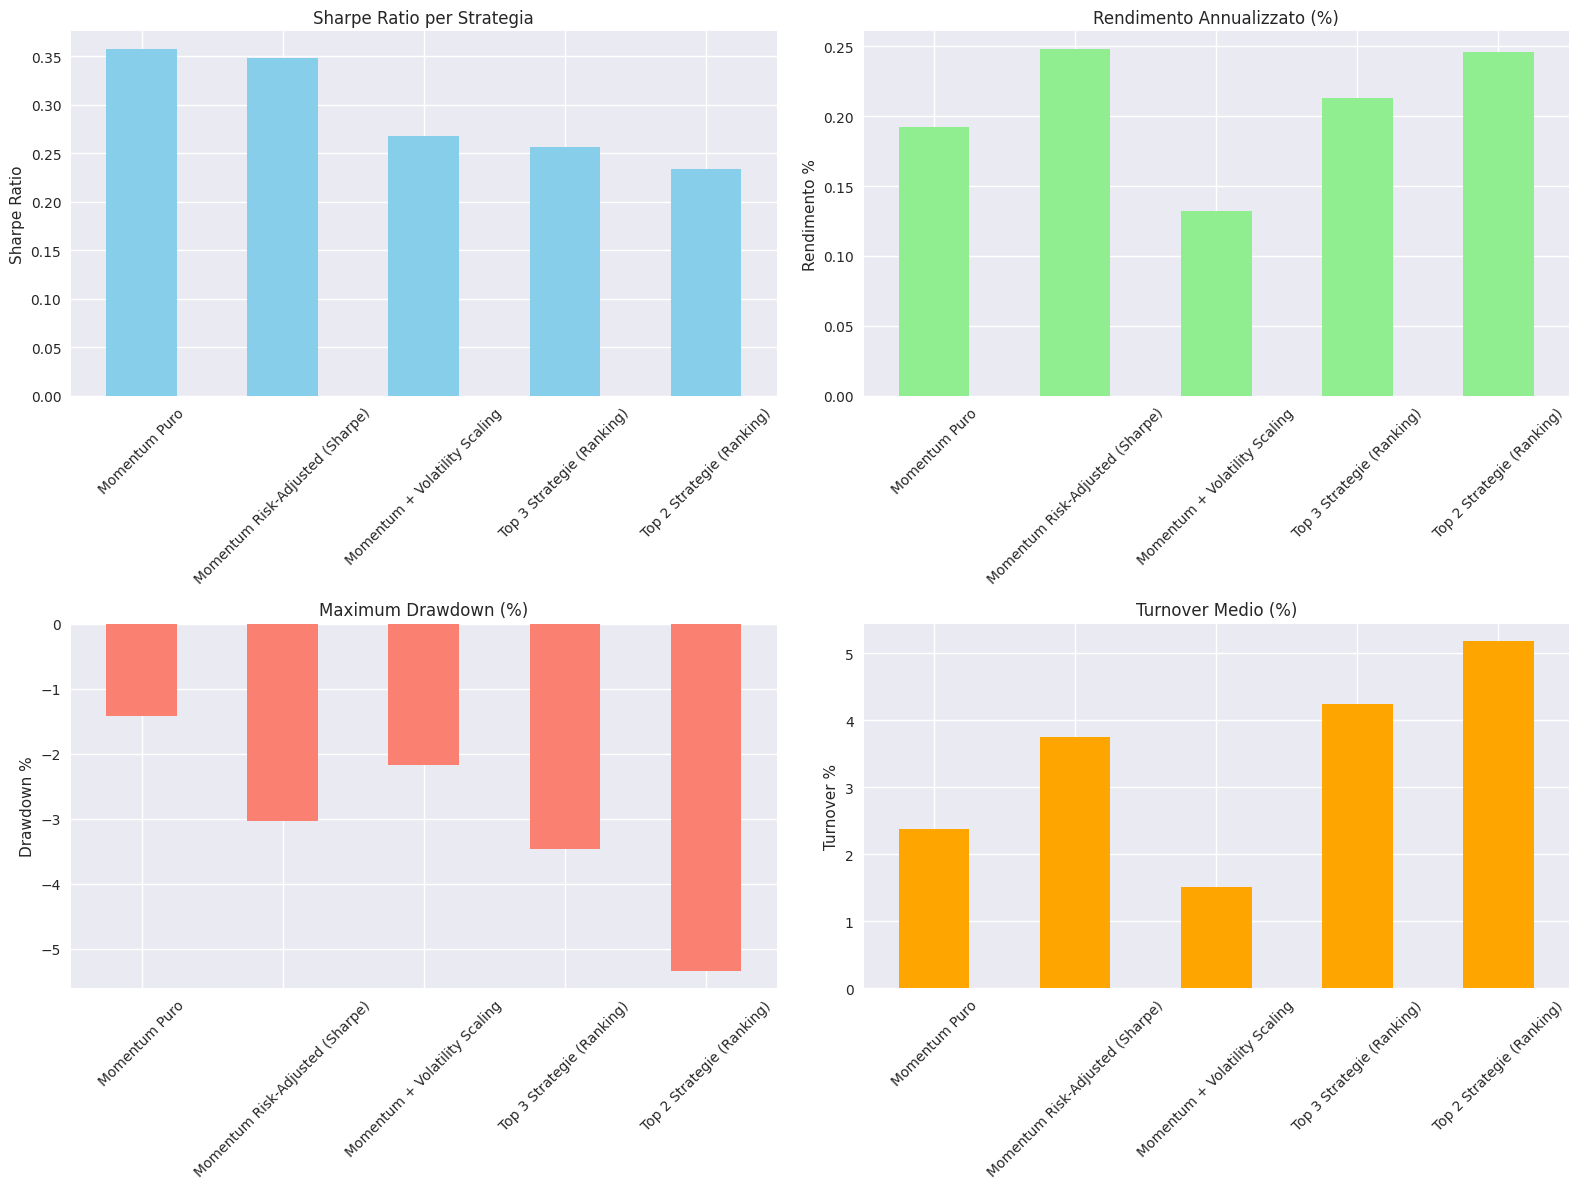

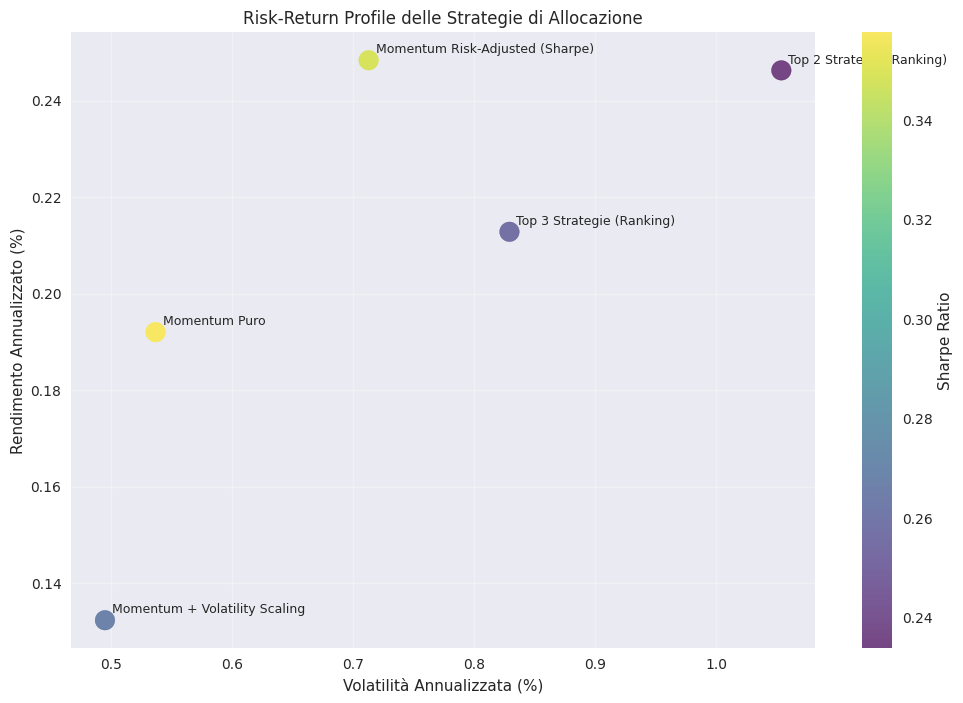


📋 TABELLA RIASSUNTIVA DELLE PERFORMANCE
                                 total_return  annualized_return  volatility  sharpe_ratio  max_drawdown  calmar_ratio  win_rate  avg_turnover  num_periods
Momentum Puro                           7.095              0.192       0.537         0.358        -1.416         0.136    47.115         2.370       1872.0
Momentum Risk-Adjusted (Sharpe)         9.243              0.248       0.713         0.349        -3.037         0.082    35.524         3.756       1872.0
Momentum + Volatility Scaling           4.828              0.132       0.495         0.267        -2.164         0.061    49.466         1.515       1872.0
Top 3 Strategie (Ranking)               7.821              0.213       0.829         0.257        -3.456         0.062    20.032         4.238       1872.0
Top 2 Strategie (Ranking)               9.041              0.246       1.054         0.234        -5.337         0.046    15.491         5.182       1872.0


In [12]:
# Crea visualizzazioni delle performance
if 'performance_df' in globals() and len(performance_df) > 0:
    
    # 1. Grafico a barre per confronto metriche principali
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sharpe Ratio
    performance_df['sharpe_ratio'].plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Sharpe Ratio per Strategia')
    axes[0,0].set_ylabel('Sharpe Ratio')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Rendimento Annualizzato
    performance_df['annualized_return'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
    axes[0,1].set_title('Rendimento Annualizzato (%)')
    axes[0,1].set_ylabel('Rendimento %')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Max Drawdown
    performance_df['max_drawdown'].plot(kind='bar', ax=axes[1,0], color='salmon')
    axes[1,0].set_title('Maximum Drawdown (%)')
    axes[1,0].set_ylabel('Drawdown %')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Turnover
    performance_df['avg_turnover'].plot(kind='bar', ax=axes[1,1], color='orange')
    axes[1,1].set_title('Turnover Medio (%)')
    axes[1,1].set_ylabel('Turnover %')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Grafico scatter Risk-Return
    plt.figure(figsize=(12, 8))
    plt.scatter(performance_df['volatility'], performance_df['annualized_return'], 
                s=200, alpha=0.7, c=performance_df['sharpe_ratio'], cmap='viridis')
    
    for i, strategy in enumerate(performance_df.index):
        plt.annotate(strategy, 
                    (performance_df.iloc[i]['volatility'], performance_df.iloc[i]['annualized_return']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatilità Annualizzata (%)')
    plt.ylabel('Rendimento Annualizzato (%)')
    plt.title('Risk-Return Profile delle Strategie di Allocazione')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Tabella comparativa
    print("\n📋 TABELLA RIASSUNTIVA DELLE PERFORMANCE")
    print("=" * 120)
    display_df = performance_df.round(3)
    print(display_df.to_string())
    
else:
    print("❌ Nessun dato di performance da visualizzare!")

📈 EQUITY CURVES - CONFRONTO STRATEGIE DI ALLOCAZIONE


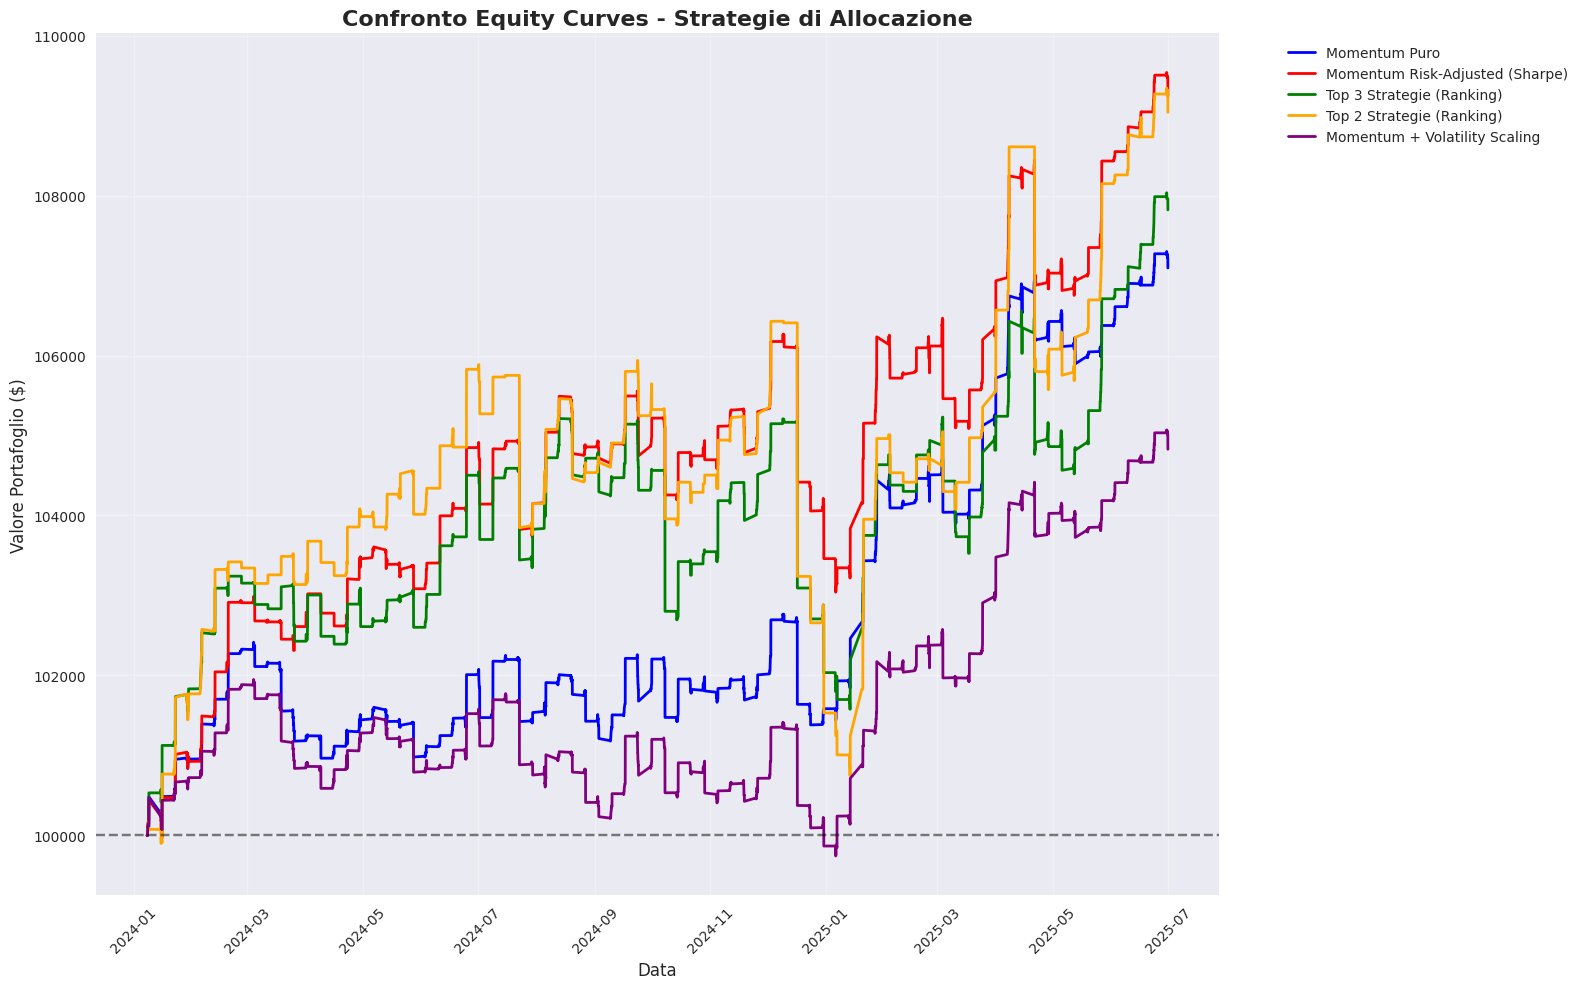

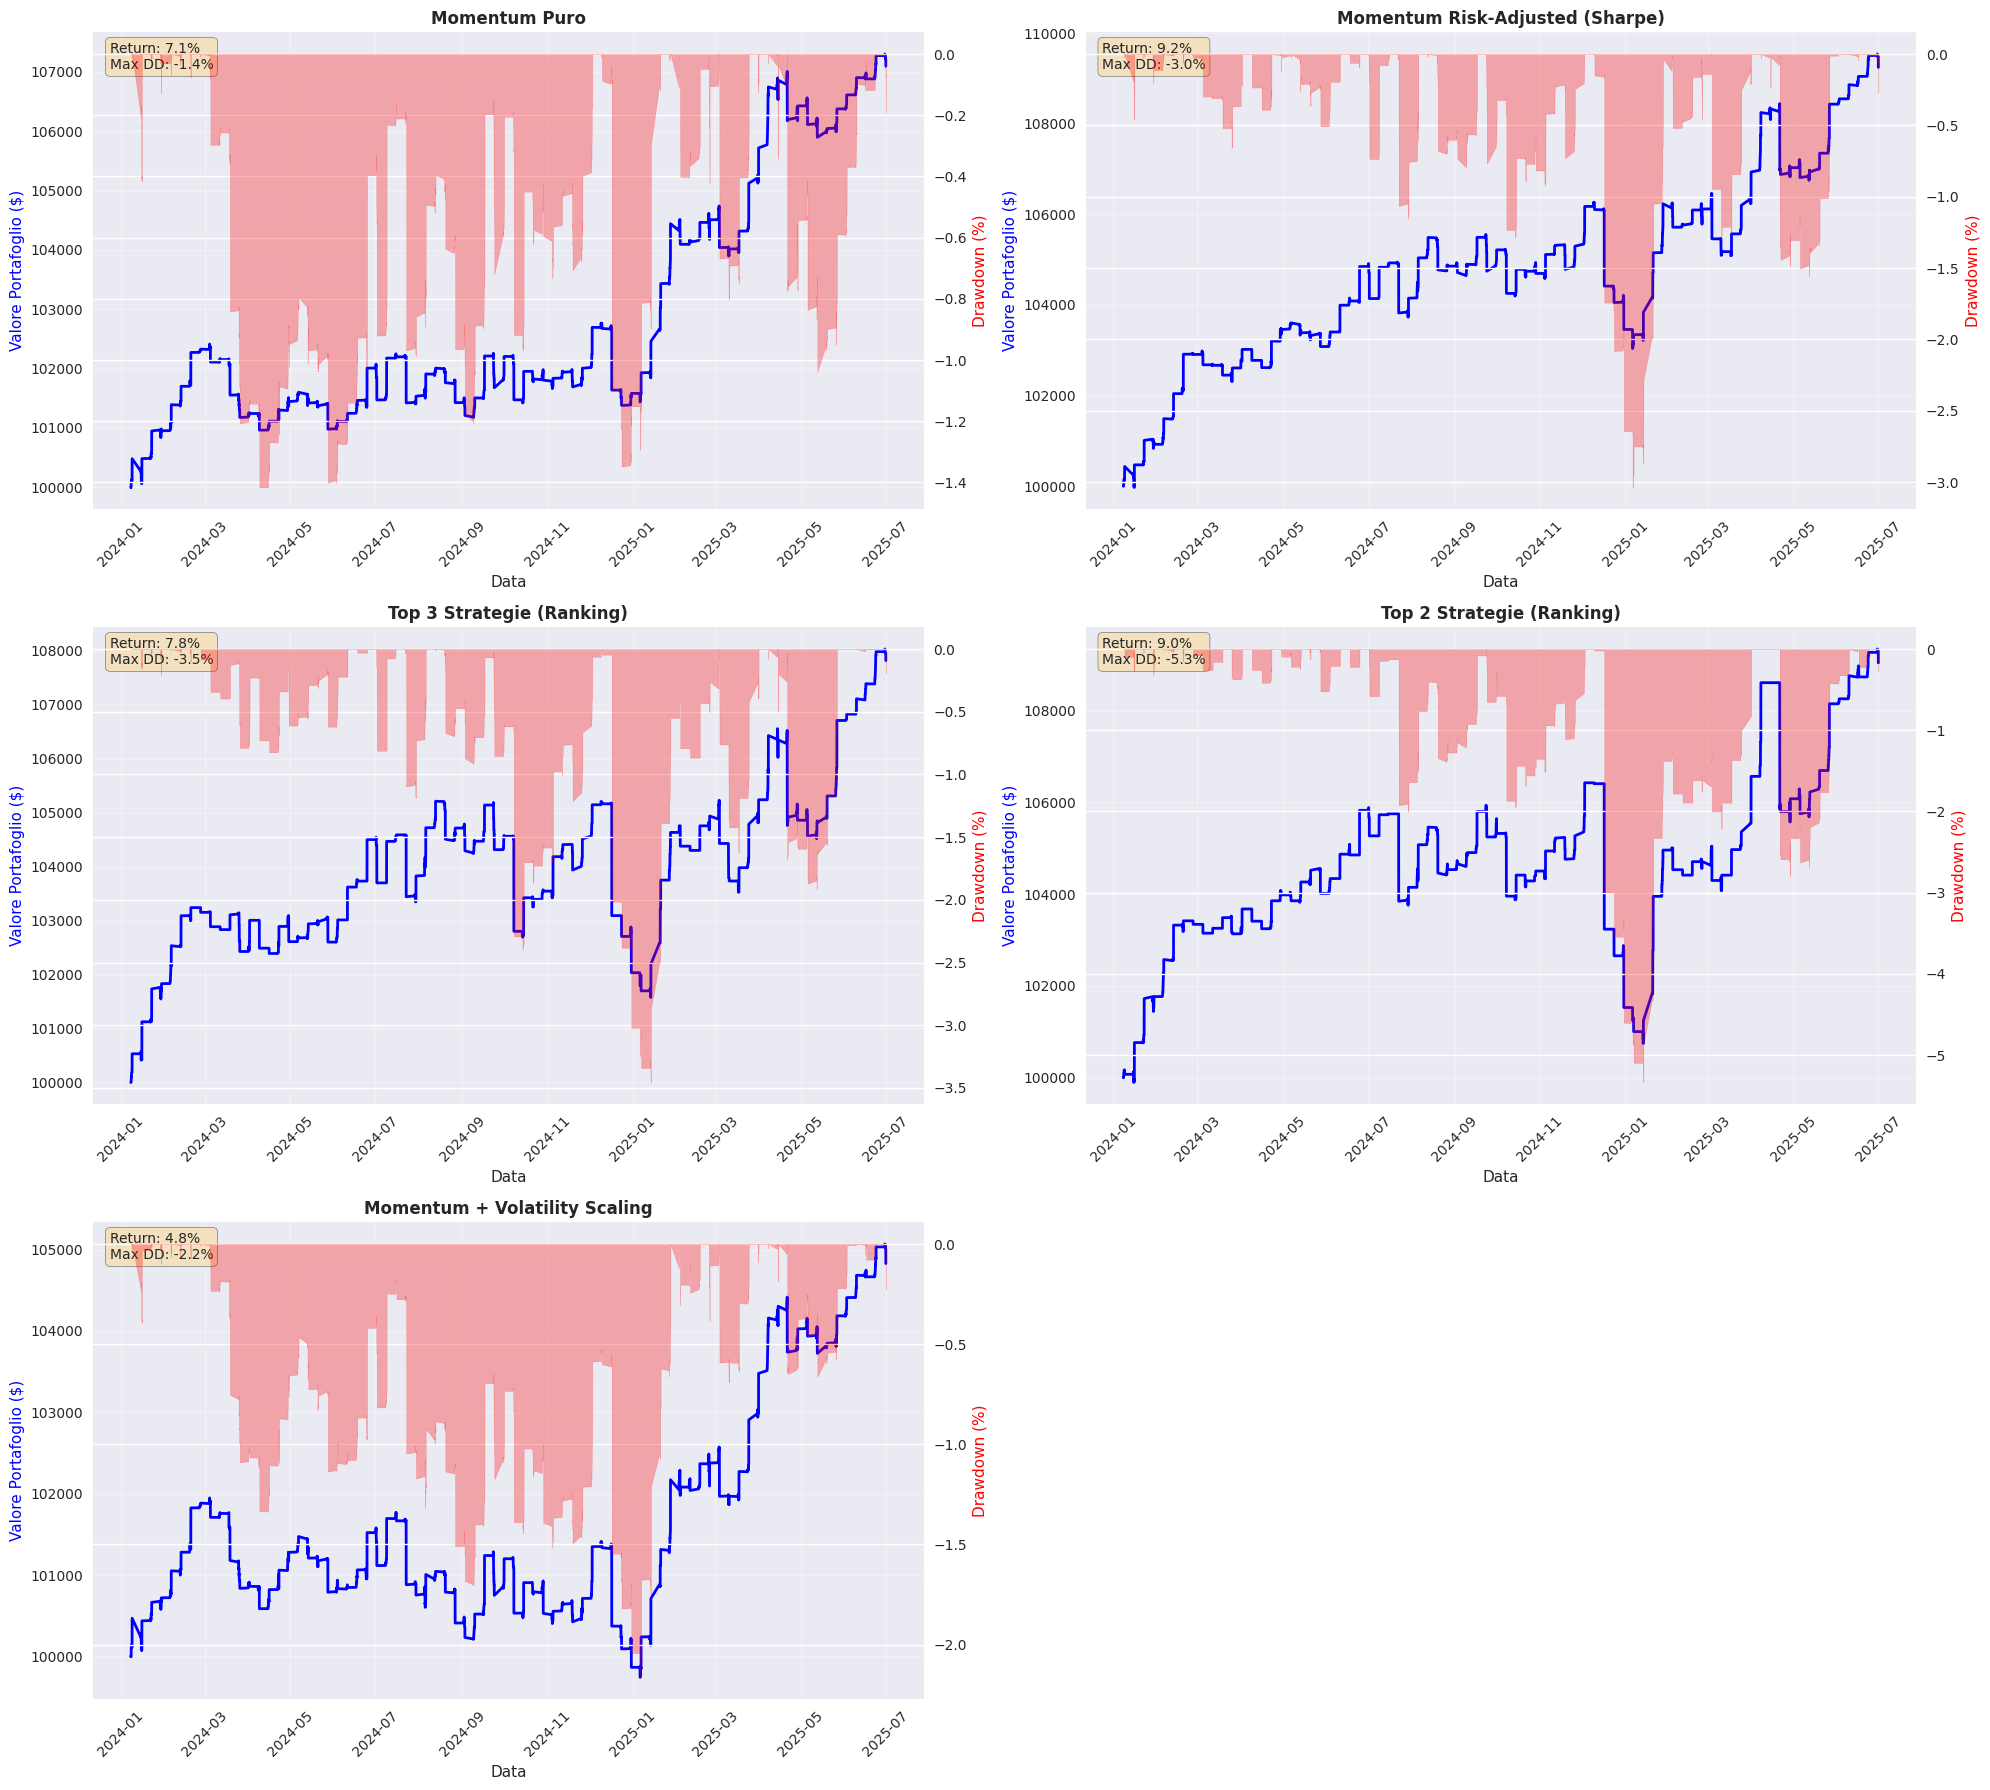


📊 SUMMARY TABLE - PERFORMANCE FINALI
                      Strategia Valore Finale Return Totale (%) Volatilità (%) Sharpe Ratio Max Drawdown (%)
                  Momentum Puro      $107,095             7.10%          0.54%        0.357           -1.42%
Momentum Risk-Adjusted (Sharpe)      $109,243             9.24%          0.71%        0.348           -3.04%
      Top 3 Strategie (Ranking)      $107,821             7.82%          0.83%        0.256           -3.46%
      Top 2 Strategie (Ranking)      $109,041             9.04%          1.05%        0.234           -5.34%
  Momentum + Volatility Scaling      $104,828             4.83%          0.50%        0.267           -2.16%


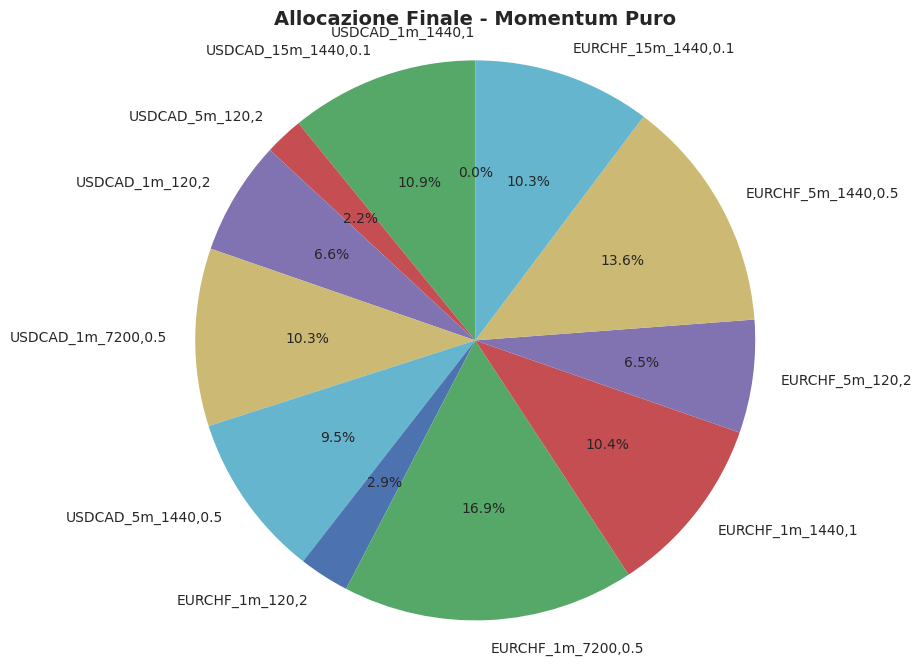


🎯 Analisi completata per 5 strategie di allocazione!


In [13]:
# Visualizza le Equity Curves di tutte le strategie di allocazione
if 'results' in globals() and results:
    
    print("📈 EQUITY CURVES - CONFRONTO STRATEGIE DI ALLOCAZIONE")
    print("=" * 70)
    
    # 1. Grafico principale con tutte le equity curves
    plt.figure(figsize=(16, 10))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    equity_data = {}
    
    for i, (strategy_name, result) in enumerate(results.items()):
        if result['portfolio_returns']:
            # Calcola la curva di equity
            returns = np.array(result['portfolio_returns'])
            equity_curve = np.cumprod(1 + returns) * 100000  # Parte da 100k
            dates = result['rebalancing_dates'][:len(returns)]
            
            equity_data[strategy_name] = {
                'dates': dates,
                'equity': equity_curve,
                'returns': returns
            }
            
            # Plot della equity curve
            plt.plot(dates, equity_curve, 
                    label=f"{strategy_name}", 
                    linewidth=2, 
                    color=colors[i % len(colors)])
    
    plt.title('Confronto Equity Curves - Strategie di Allocazione', fontsize=16, fontweight='bold')
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Valore Portafoglio ($)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Aggiungi linea di riferimento (capitale iniziale)
    plt.axhline(y=100000, color='black', linestyle='--', alpha=0.5, label='Capitale Iniziale')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Subplot individuali per ogni strategia con drawdown
    n_strategies = len(equity_data)
    n_cols = 2
    n_rows = (n_strategies + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    if n_strategies == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (strategy_name, data) in enumerate(equity_data.items()):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        # Calcola drawdown
        equity = data['equity']
        running_max = np.maximum.accumulate(equity)
        drawdown = (equity - running_max) / running_max * 100
        
        # Plot equity curve
        ax2 = ax.twinx()
        
        line1 = ax.plot(data['dates'], equity, 'b-', linewidth=2, label='Equity')
        line2 = ax2.fill_between(data['dates'], drawdown, 0, alpha=0.3, color='red', label='Drawdown')
        
        ax.set_title(f'{strategy_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Data')
        ax.set_ylabel('Valore Portafoglio ($)', color='blue')
        ax2.set_ylabel('Drawdown (%)', color='red')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Aggiungi statistiche nel grafico
        final_value = equity[-1]
        total_return = (final_value / 100000 - 1) * 100
        max_dd = drawdown.min()
        
        textstr = f'Return: {total_return:.1f}%\nMax DD: {max_dd:.1f}%'
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Nasconde subplot extra se numero dispari di strategie
    if n_strategies % 2 == 1 and n_strategies > 1:
        axes[-1, -1].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Tabella riassuntiva delle performance finali
    print("\n📊 SUMMARY TABLE - PERFORMANCE FINALI")
    print("=" * 80)
    
    summary_data = []
    for strategy_name, data in equity_data.items():
        final_value = data['equity'][-1]
        total_return = (final_value / 100000 - 1) * 100
        
        returns = data['returns']
        volatility = np.std(returns) * np.sqrt(52) * 100  # Annualizzata
        sharpe = (np.mean(returns) * 52) / (np.std(returns) * np.sqrt(52)) if np.std(returns) > 0 else 0
        
        # Drawdown
        equity = data['equity']
        running_max = np.maximum.accumulate(equity)
        drawdown = (equity - running_max) / running_max * 100
        max_dd = drawdown.min()
        
        summary_data.append({
            'Strategia': strategy_name,
            'Valore Finale': f"${final_value:,.0f}",
            'Return Totale (%)': f"{total_return:.2f}%",
            'Volatilità (%)': f"{volatility:.2f}%",
            'Sharpe Ratio': f"{sharpe:.3f}",
            'Max Drawdown (%)': f"{max_dd:.2f}%"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # 4. Grafico a torta dell'allocazione finale per la strategia migliore
    if 'performance_df' in globals() and len(performance_df) > 0:
        best_strategy = performance_df.index[0]
        if best_strategy in results:
            final_allocation = results[best_strategy]['allocation_history'][-1]
            
            plt.figure(figsize=(10, 8))
            plt.pie(final_allocation.values(), 
                   labels=final_allocation.keys(), 
                   autopct='%1.1f%%',
                   startangle=90)
            plt.title(f'Allocazione Finale - {best_strategy}', fontsize=14, fontweight='bold')
            plt.axis('equal')
            plt.show()
    
    print(f"\n🎯 Analisi completata per {len(equity_data)} strategie di allocazione!")
    
else:
    print("❌ Nessun risultato disponibile per le equity curves!")


📊 EVOLUZIONE ALLOCAZIONI - Momentum Puro


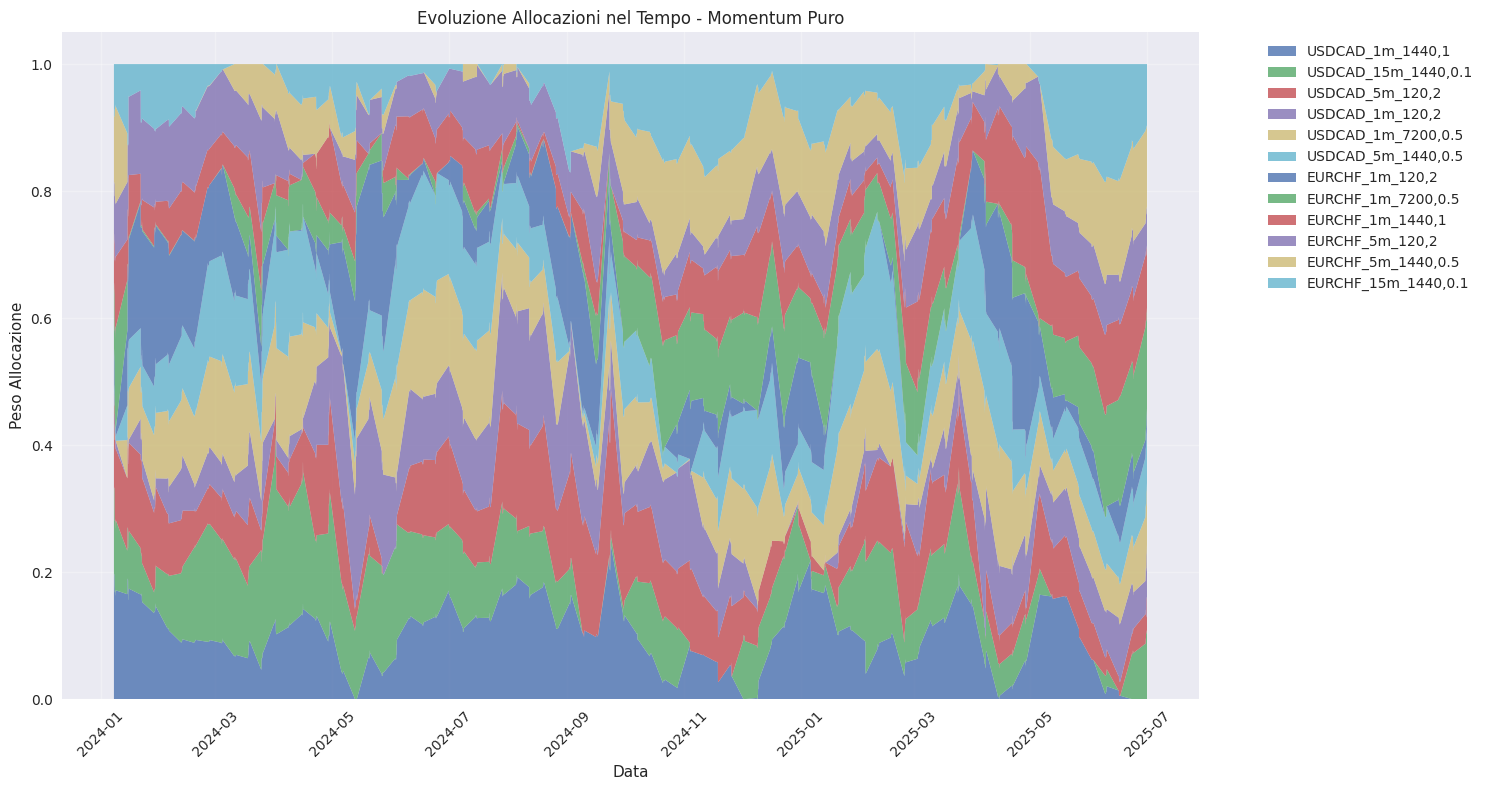


📈 STATISTICHE ALLOCAZIONI per Momentum Puro:
  🎯 USDCAD_1m_1440,1:
      Media: 10.0%, Max: 25.1%, Min: 0.0%
  🎯 USDCAD_15m_1440,0.1:
      Media: 9.2%, Max: 28.9%, Min: 0.0%
  🎯 USDCAD_5m_120,2:
      Media: 9.1%, Max: 23.1%, Min: 0.0%
  🎯 USDCAD_1m_120,2:
      Media: 8.2%, Max: 25.7%, Min: 0.0%
  🎯 USDCAD_1m_7200,0.5:
      Media: 9.8%, Max: 20.7%, Min: 0.0%
  🎯 USDCAD_5m_1440,0.5:
      Media: 10.0%, Max: 21.6%, Min: 0.0%
  🎯 EURCHF_1m_120,2:
      Media: 7.6%, Max: 29.4%, Min: 0.0%
  🎯 EURCHF_1m_7200,0.5:
      Media: 6.8%, Max: 17.7%, Min: 0.0%
  🎯 EURCHF_1m_1440,1:
      Media: 7.7%, Max: 24.7%, Min: 0.0%
  🎯 EURCHF_5m_120,2:
      Media: 7.6%, Max: 17.6%, Min: 0.0%
  🎯 EURCHF_5m_1440,0.5:
      Media: 6.5%, Max: 17.8%, Min: 0.0%
  🎯 EURCHF_15m_1440,0.1:
      Media: 7.5%, Max: 18.8%, Min: 0.0%


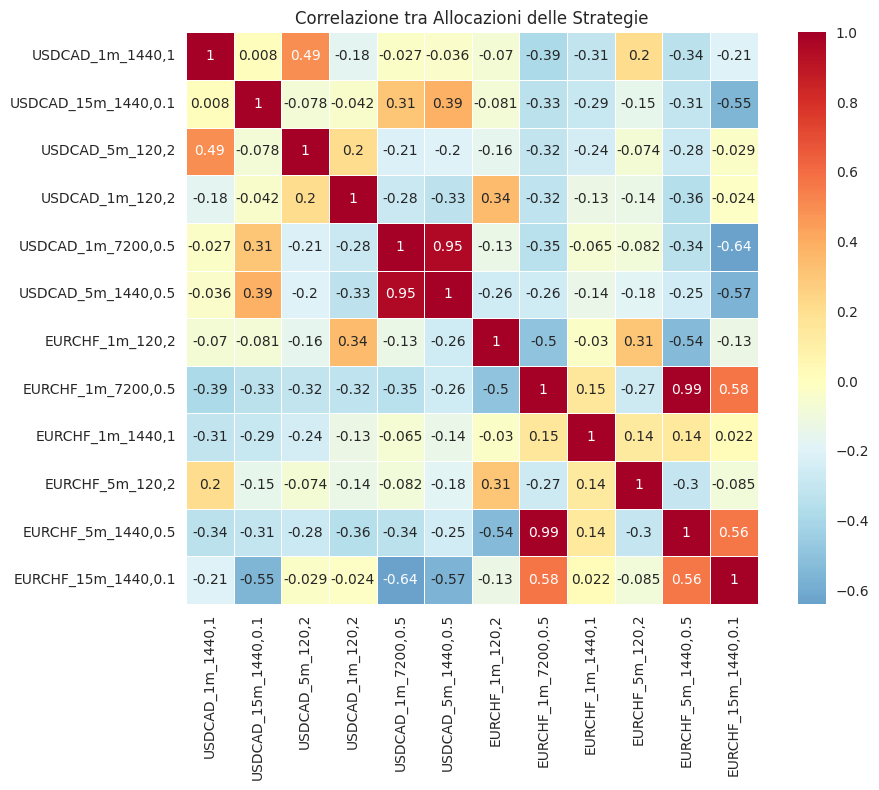

In [14]:
# Visualizza l'evoluzione delle allocazioni per la strategia migliore
if 'results' in globals() and 'performance_df' in globals() and len(performance_df) > 0:
    
    best_strategy = performance_df.index[0]
    best_result = results[best_strategy]
    
    print(f"\n📊 EVOLUZIONE ALLOCAZIONI - {best_strategy}")
    print("=" * 60)
    
    # Crea DataFrame delle allocazioni
    allocation_df = pd.DataFrame(best_result['allocation_history'])
    allocation_df.index = best_result['rebalancing_dates']
    
    # Grafico dell'evoluzione delle allocazioni
    plt.figure(figsize=(15, 8))
    
    # Stacked area chart
    plt.stackplot(allocation_df.index, 
                 *[allocation_df[col] for col in allocation_df.columns],
                 labels=allocation_df.columns,
                 alpha=0.8)
    
    plt.xlabel('Data')
    plt.ylabel('Peso Allocazione')
    plt.title(f'Evoluzione Allocazioni nel Tempo - {best_strategy}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Statistiche delle allocazioni
    print(f"\n📈 STATISTICHE ALLOCAZIONI per {best_strategy}:")
    for strategy in allocation_df.columns:
        avg_allocation = allocation_df[strategy].mean() * 100
        max_allocation = allocation_df[strategy].max() * 100
        min_allocation = allocation_df[strategy].min() * 100
        print(f"  🎯 {strategy}:")
        print(f"      Media: {avg_allocation:.1f}%, Max: {max_allocation:.1f}%, Min: {min_allocation:.1f}%")
    
    # Correlazione tra allocazioni
    correlation_matrix = allocation_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
                square=True, linewidths=0.5)
    plt.title('Correlazione tra Allocazioni delle Strategie')
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Impossibile visualizzare l'evoluzione delle allocazioni!")


📈 EQUITY CURVES DELLE STRATEGIE DI ALLOCAZIONE
📊 Momentum Puro:
   💰 Valore Iniziale: €100,000
   💰 Valore Finale: €107,095.30
   📈 Rendimento Totale: 7.10%
📊 Momentum Risk-Adjusted (Sharpe):
   💰 Valore Iniziale: €100,000
   💰 Valore Finale: €109,243.43
   📈 Rendimento Totale: 9.24%
📊 Top 3 Strategie (Ranking):
   💰 Valore Iniziale: €100,000
   💰 Valore Finale: €107,821.01
   📈 Rendimento Totale: 7.82%
📊 Top 2 Strategie (Ranking):
   💰 Valore Iniziale: €100,000
   💰 Valore Finale: €109,041.40
   📈 Rendimento Totale: 9.04%
📊 Momentum + Volatility Scaling:
   💰 Valore Iniziale: €100,000
   💰 Valore Finale: €104,828.42
   📈 Rendimento Totale: 4.83%


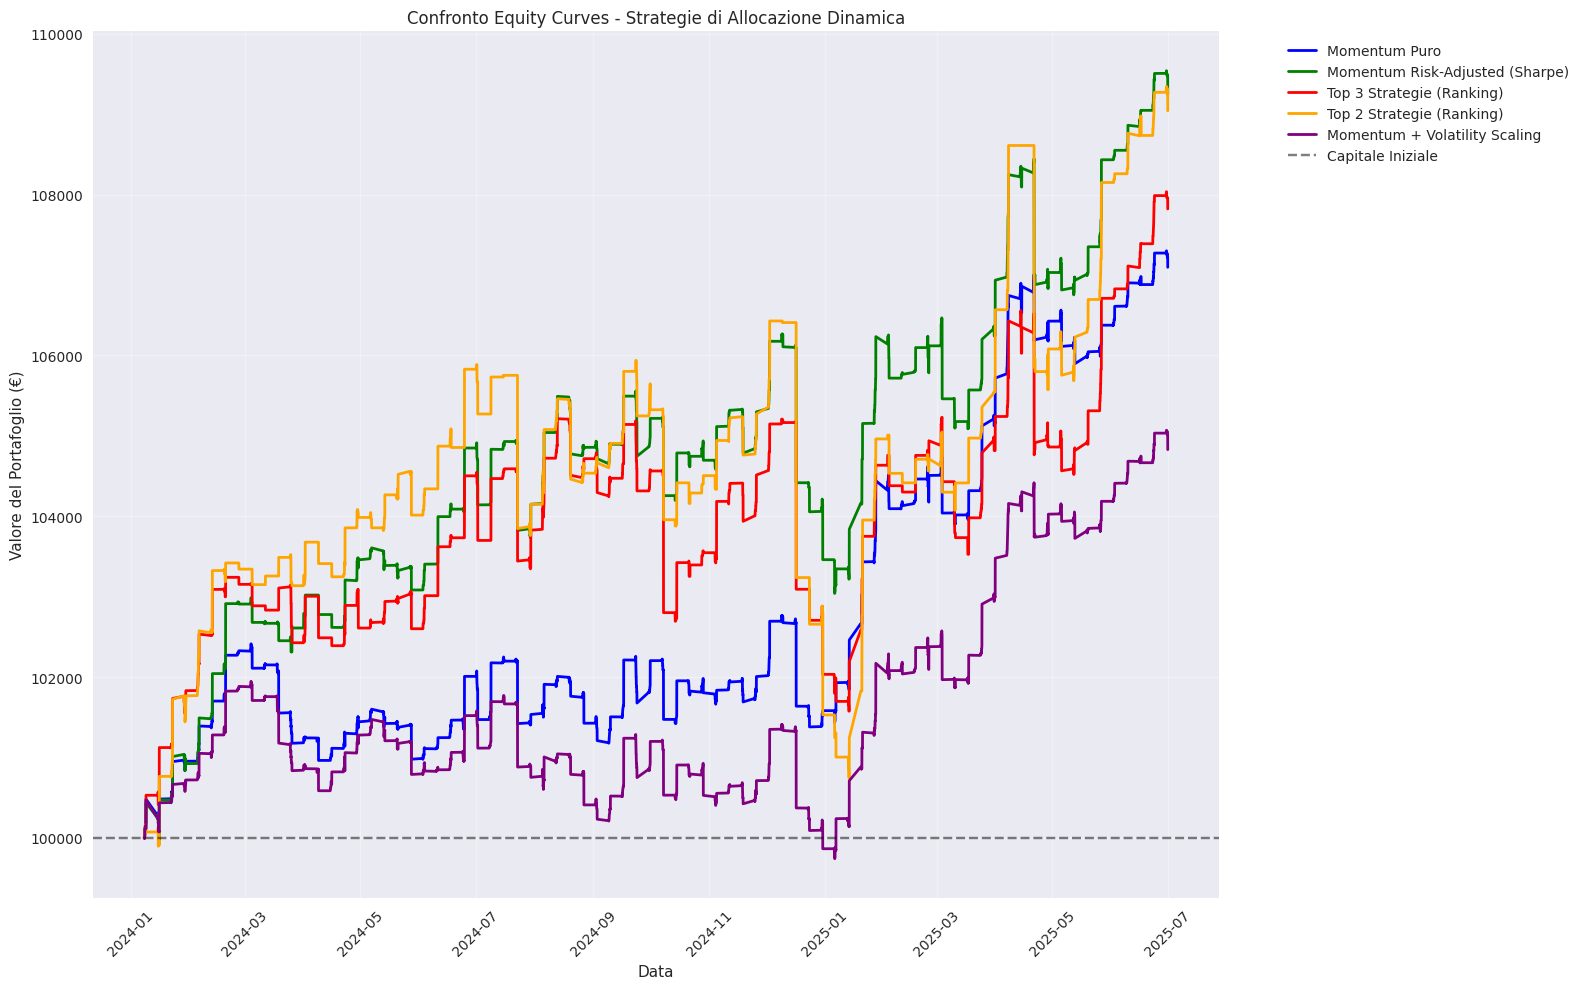

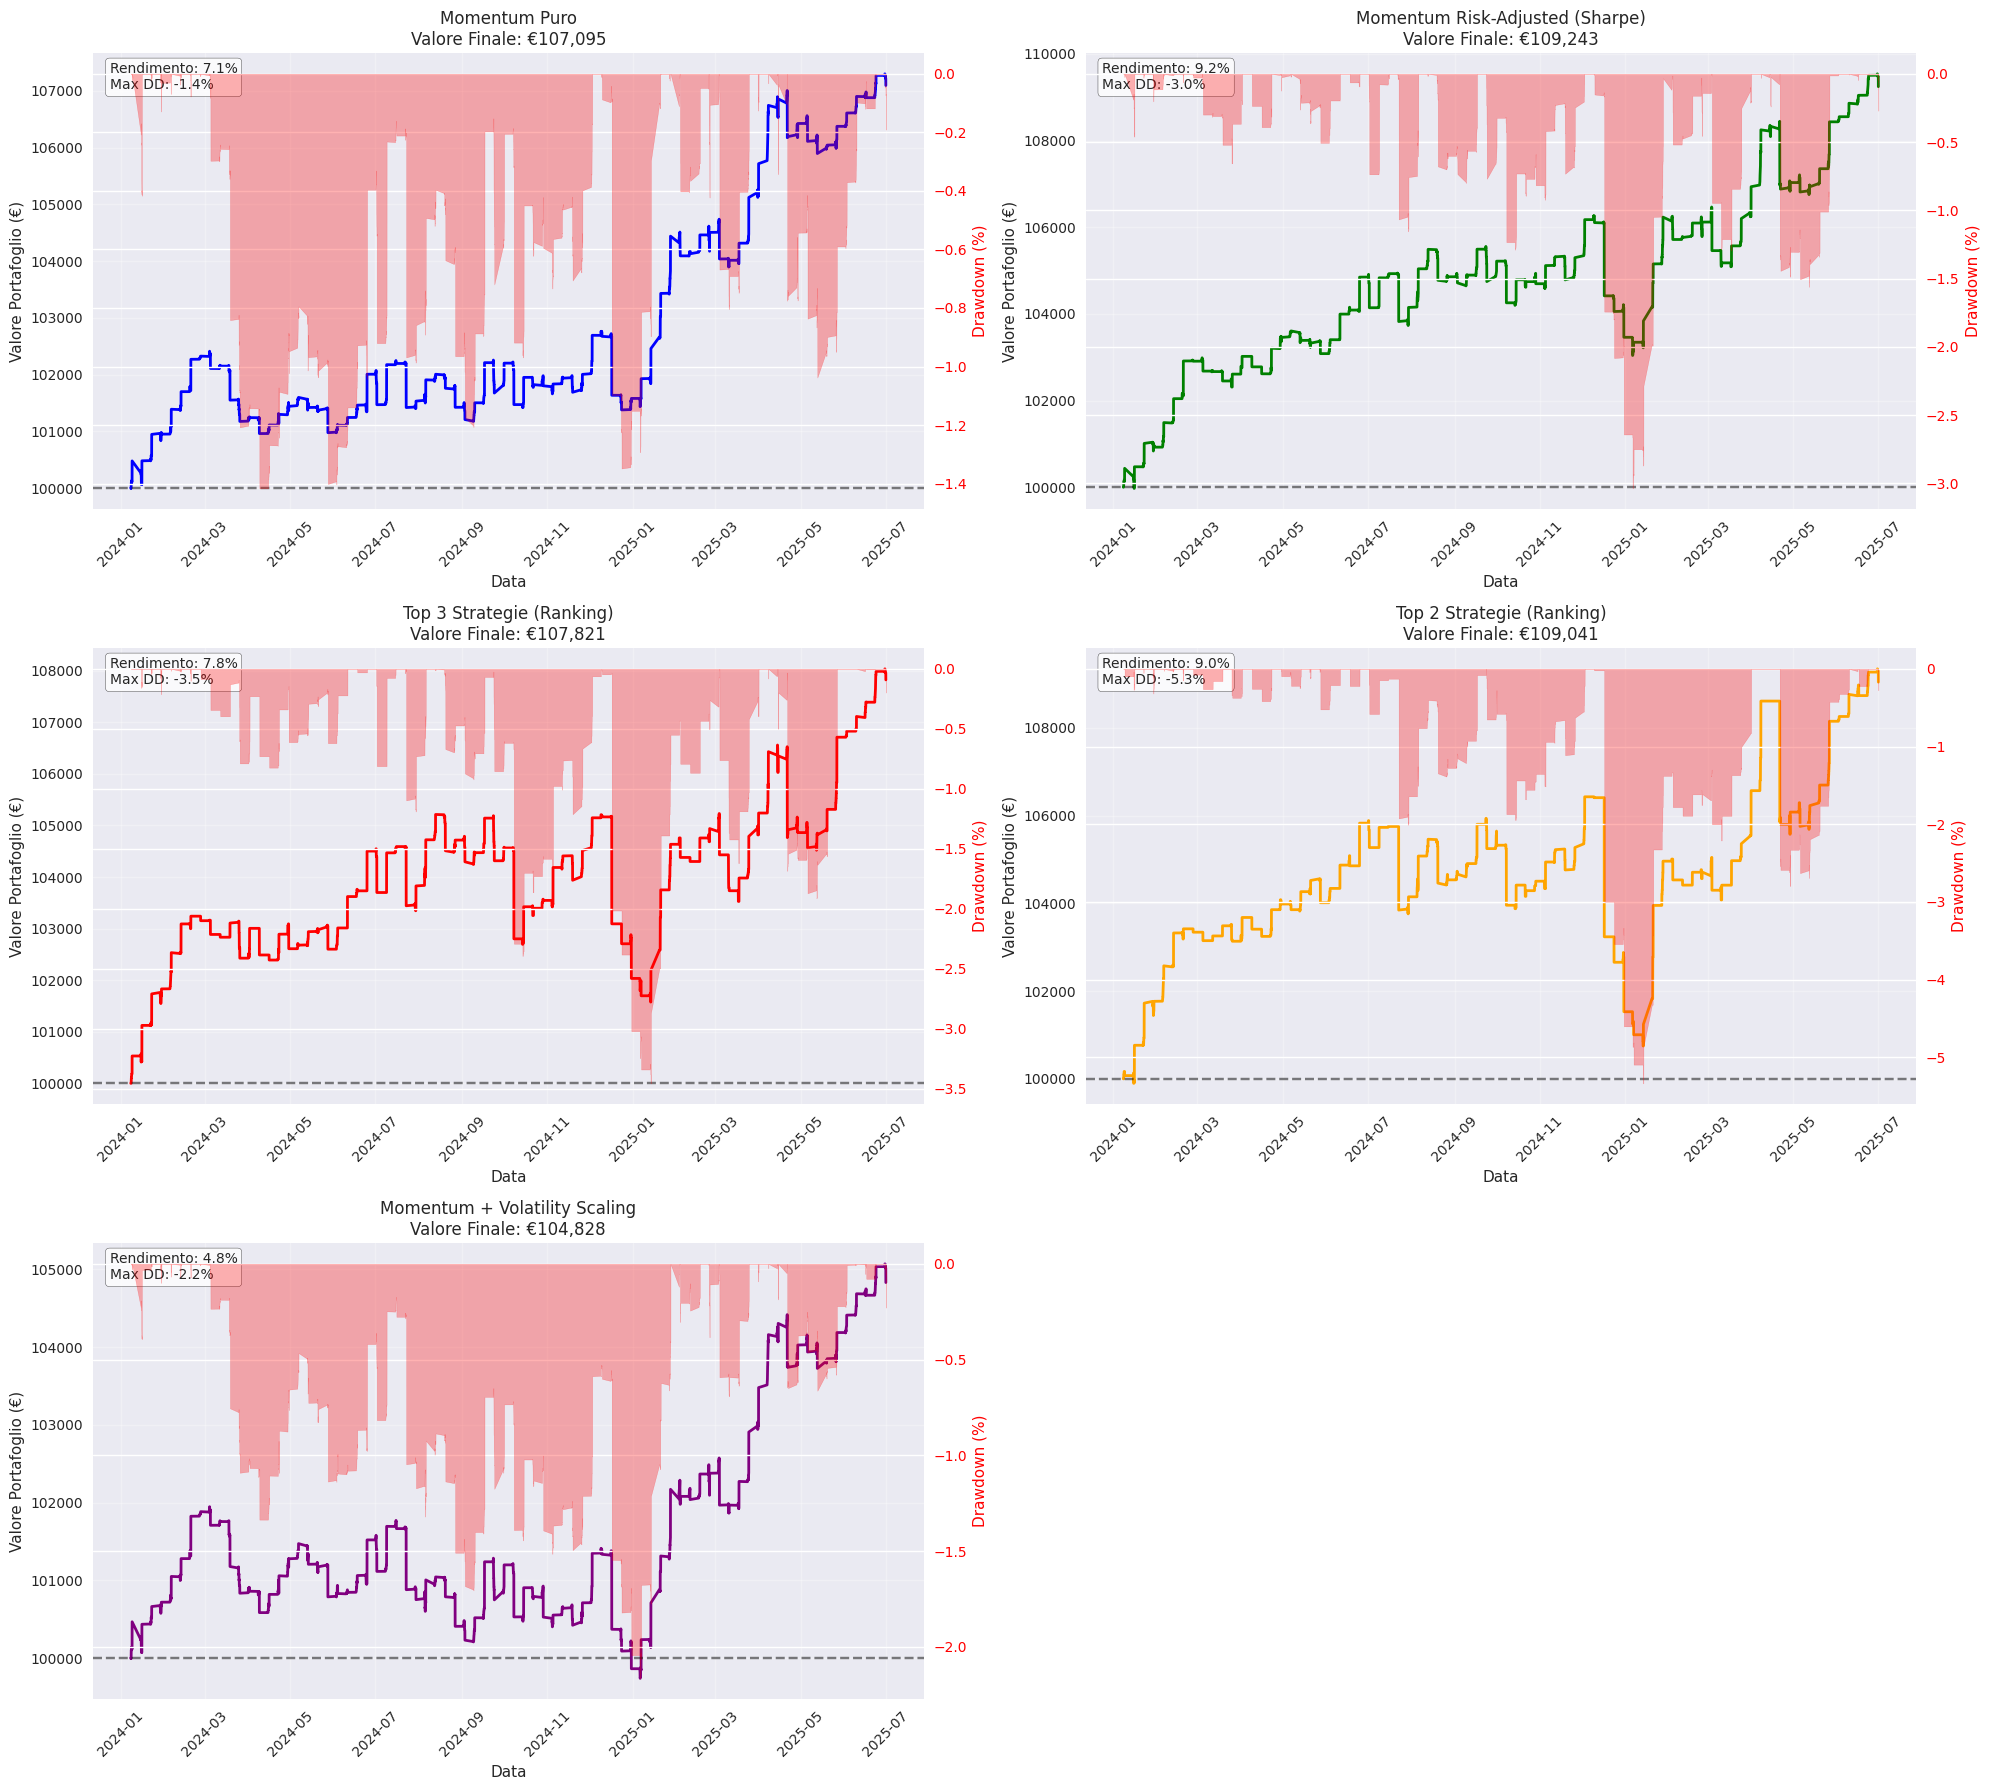


📋 ANALISI COMPARATIVA EQUITY CURVES
                                 Valore_Finale  Rendimento_Totale_%  Max_Drawdown_%  Calmar_Ratio  Periodi_Underwater_Avg  Periodi_Underwater_Max
Strategia                                                                                                                                        
Momentum Risk-Adjusted (Sharpe)      109243.43                 9.24           -3.04          0.39                   64.00                     124
Top 2 Strategie (Ranking)            109041.40                 9.04           -5.34          0.22                  115.00                     337
Top 3 Strategie (Ranking)            107821.01                 7.82           -3.46          0.29                   64.57                     134
Momentum Puro                        107095.30                 7.10           -1.42          0.65                   26.50                     112
Momentum + Volatility Scaling        104828.42                 4.83           -2.16    

In [15]:
# Visualizza le equity curves per tutte le strategie testate
if 'results' in globals() and len(results) > 0:
    
    print("\n📈 EQUITY CURVES DELLE STRATEGIE DI ALLOCAZIONE")
    print("=" * 60)
    
    # Crea una figura per confrontare tutte le equity curves
    plt.figure(figsize=(16, 10))
    
    # Colori per distinguere le strategie
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']
    
    # Dizionario per raccogliere i dati delle equity curves
    all_equity_curves = {}
    
    for i, (strategy_name, result) in enumerate(results.items()):
        if result and result['portfolio_returns']:
            # Calcola l'equity curve
            returns = np.array(result['portfolio_returns'])
            equity_curve = 100000 * (1 + returns).cumprod()  # Inizia da 100,000
            
            # Date corrispondenti
            dates = result['rebalancing_dates'][:len(returns)]
            
            # Plot della curva
            color = colors[i % len(colors)]
            plt.plot(dates, equity_curve, label=strategy_name, linewidth=2, color=color)
            
            # Salva per analisi successiva
            all_equity_curves[strategy_name] = {
                'dates': dates,
                'equity': equity_curve,
                'returns': returns
            }
            
            print(f"📊 {strategy_name}:")
            print(f"   💰 Valore Iniziale: €100,000")
            print(f"   💰 Valore Finale: €{equity_curve[-1]:,.2f}")
            print(f"   📈 Rendimento Totale: {((equity_curve[-1]/100000)-1)*100:.2f}%")
    
    # Aggiungi linea di riferimento (100k iniziale)
    if all_equity_curves:
        min_date = min([data['dates'][0] for data in all_equity_curves.values()])
        max_date = max([data['dates'][-1] for data in all_equity_curves.values()])
        plt.axhline(y=100000, color='black', linestyle='--', alpha=0.5, label='Capitale Iniziale')
    
    plt.xlabel('Data')
    plt.ylabel('Valore del Portafoglio (€)')
    plt.title('Confronto Equity Curves - Strategie di Allocazione Dinamica')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Crea subplot individuali per ogni strategia
    if len(all_equity_curves) > 1:
        n_strategies = len(all_equity_curves)
        n_cols = 2
        n_rows = (n_strategies + 1) // 2
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
        
        for i, (strategy_name, data) in enumerate(all_equity_curves.items()):
            ax = axes[i]
            
            # Plot equity curve
            ax.plot(data['dates'], data['equity'], linewidth=2, color=colors[i % len(colors)])
            ax.axhline(y=100000, color='black', linestyle='--', alpha=0.5)
            
            # Calcola drawdown
            running_max = np.maximum.accumulate(data['equity'])
            drawdown = (data['equity'] - running_max) / running_max * 100
            
            # Aggiungi area del drawdown
            ax2 = ax.twinx()
            ax2.fill_between(data['dates'], drawdown, 0, alpha=0.3, color='red', label='Drawdown')
            ax2.set_ylabel('Drawdown (%)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            
            # Formattazione
            ax.set_title(f'{strategy_name}\nValore Finale: €{data["equity"][-1]:,.0f}')
            ax.set_xlabel('Data')
            ax.set_ylabel('Valore Portafoglio (€)')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            
            # Statistiche rapide
            final_return = ((data['equity'][-1]/100000)-1)*100
            max_dd = drawdown.min()
            ax.text(0.02, 0.98, f'Rendimento: {final_return:.1f}%\nMax DD: {max_dd:.1f}%',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Rimuovi subplot vuoti se necessario
        for j in range(len(all_equity_curves), len(axes)):
            axes[j].remove()
        
        plt.tight_layout()
        plt.show()
    
    # Analisi comparativa delle equity curves
    print(f"\n📋 ANALISI COMPARATIVA EQUITY CURVES")
    print("=" * 70)
    
    comparison_data = []
    for strategy_name, data in all_equity_curves.items():
        equity = data['equity']
        returns = data['returns']
        
        # Calcola metriche aggiuntive
        total_return = ((equity[-1]/100000)-1)*100
        
        # Drawdown analysis
        running_max = np.maximum.accumulate(equity)
        drawdown = (equity - running_max) / running_max * 100
        max_drawdown = drawdown.min()
        
        # Calmar ratio
        annualized_return = ((equity[-1]/100000)**(252/len(returns)) - 1) * 100
        calmar = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
        
        # Underwater periods
        underwater = drawdown < -1  # Periodi con drawdown > 1%
        if underwater.any():
            underwater_periods = np.diff(np.concatenate(([False], underwater, [False]))).nonzero()[0]
            if len(underwater_periods) % 2 == 1:
                underwater_periods = np.append(underwater_periods, len(underwater))
            underwater_lengths = underwater_periods[1::2] - underwater_periods[::2]
            avg_underwater = np.mean(underwater_lengths) if len(underwater_lengths) > 0 else 0
            max_underwater = np.max(underwater_lengths) if len(underwater_lengths) > 0 else 0
        else:
            avg_underwater = 0
            max_underwater = 0
        
        comparison_data.append({
            'Strategia': strategy_name,
            'Valore_Finale': equity[-1],
            'Rendimento_Totale_%': total_return,
            'Max_Drawdown_%': max_drawdown,
            'Calmar_Ratio': calmar,
            'Periodi_Underwater_Avg': avg_underwater,
            'Periodi_Underwater_Max': max_underwater
        })
    
    # Crea DataFrame per il confronto
    comparison_df = pd.DataFrame(comparison_data).set_index('Strategia')
    comparison_df = comparison_df.sort_values('Rendimento_Totale_%', ascending=False)
    
    print(comparison_df.round(2).to_string())
    
    # Identifica la strategia con la migliore equity curve
    best_equity_strategy = comparison_df.index[0]
    print(f"\n🏆 MIGLIORE EQUITY CURVE: {best_equity_strategy}")
    print(f"   💰 Valore Finale: €{comparison_df.loc[best_equity_strategy, 'Valore_Finale']:,.2f}")
    print(f"   📈 Rendimento Totale: {comparison_df.loc[best_equity_strategy, 'Rendimento_Totale_%']:.2f}%")
    print(f"   💥 Max Drawdown: {comparison_df.loc[best_equity_strategy, 'Max_Drawdown_%']:.2f}%")

else:
    print("❌ Nessun risultato disponibile per creare le equity curves!")

## 6. Ottimizzazione dei Parametri

Testiamo diverse configurazioni per trovare i parametri ottimali:
- Diversi lookback window (15, 30, 60 giorni)
- Diverse soglie per il ranking
- Combinazioni di metriche

🔧 OTTIMIZZAZIONE PARAMETRI STRATEGIE

🕒 Testing lookback window: 15 giorni

🧪 Testing Risk-Adjusted (Lookback 15d)...
   📅 Date ribilanciamento disponibili: 1873
   📊 Periodo 10: Portfolio Value = 100122.48
   📊 Periodo 20: Portfolio Value = 100140.80
   📊 Periodo 30: Portfolio Value = 100266.50
   📊 Periodo 40: Portfolio Value = 100004.89
   📊 Periodo 50: Portfolio Value = 100473.10
   📊 Periodo 30: Portfolio Value = 100266.50
   📊 Periodo 40: Portfolio Value = 100004.89
   📊 Periodo 50: Portfolio Value = 100473.10
   📊 Periodo 60: Portfolio Value = 100486.29
   📊 Periodo 70: Portfolio Value = 100577.54
   📊 Periodo 80: Portfolio Value = 101205.23
   📊 Periodo 60: Portfolio Value = 100486.29
   📊 Periodo 70: Portfolio Value = 100577.54
   📊 Periodo 80: Portfolio Value = 101205.23
   📊 Periodo 90: Portfolio Value = 101049.96
   📊 Periodo 100: Portfolio Value = 101043.97
   📊 Periodo 110: Portfolio Value = 101135.03
   📊 Periodo 90: Portfolio Value = 101049.96
   📊 Periodo 100: Portfoli

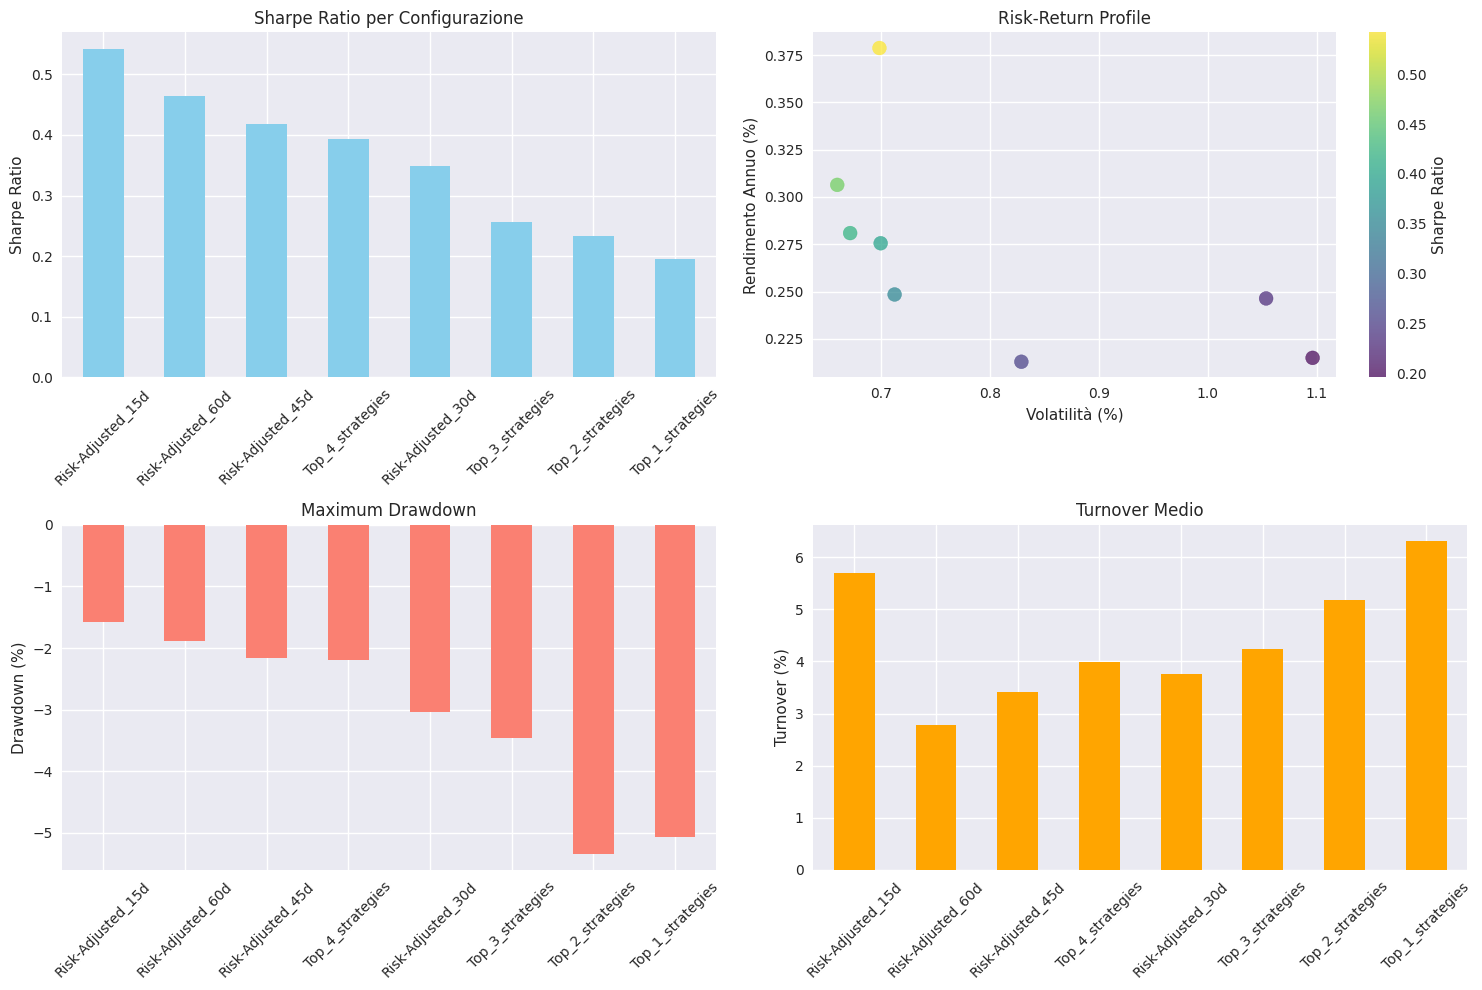


🏆 CONFIGURAZIONE OTTIMALE: Risk-Adjusted_15d
    Sharpe Ratio: 0.542
    Rendimento Annuo: 0.38%
    Max Drawdown: -1.58%

📈 GENERAZIONE EQUITY CURVES - TOP 5 CONFIGURAZIONI
🔄 Rieseguendo backtest per: Risk-Adjusted_15d

🧪 Testing Risk-Adjusted_15d...
   📅 Date ribilanciamento disponibili: 1873
   📊 Periodo 10: Portfolio Value = 100122.48
   📊 Periodo 20: Portfolio Value = 100140.80
   📊 Periodo 30: Portfolio Value = 100266.50
   📊 Periodo 20: Portfolio Value = 100140.80
   📊 Periodo 30: Portfolio Value = 100266.50
   📊 Periodo 40: Portfolio Value = 100004.89
   📊 Periodo 50: Portfolio Value = 100473.10
   📊 Periodo 60: Portfolio Value = 100486.29
   📊 Periodo 40: Portfolio Value = 100004.89
   📊 Periodo 50: Portfolio Value = 100473.10
   📊 Periodo 60: Portfolio Value = 100486.29
   📊 Periodo 70: Portfolio Value = 100577.54
   📊 Periodo 80: Portfolio Value = 101205.23
   📊 Periodo 90: Portfolio Value = 101049.96
   📊 Periodo 70: Portfolio Value = 100577.54
   📊 Periodo 80: Portfolio V

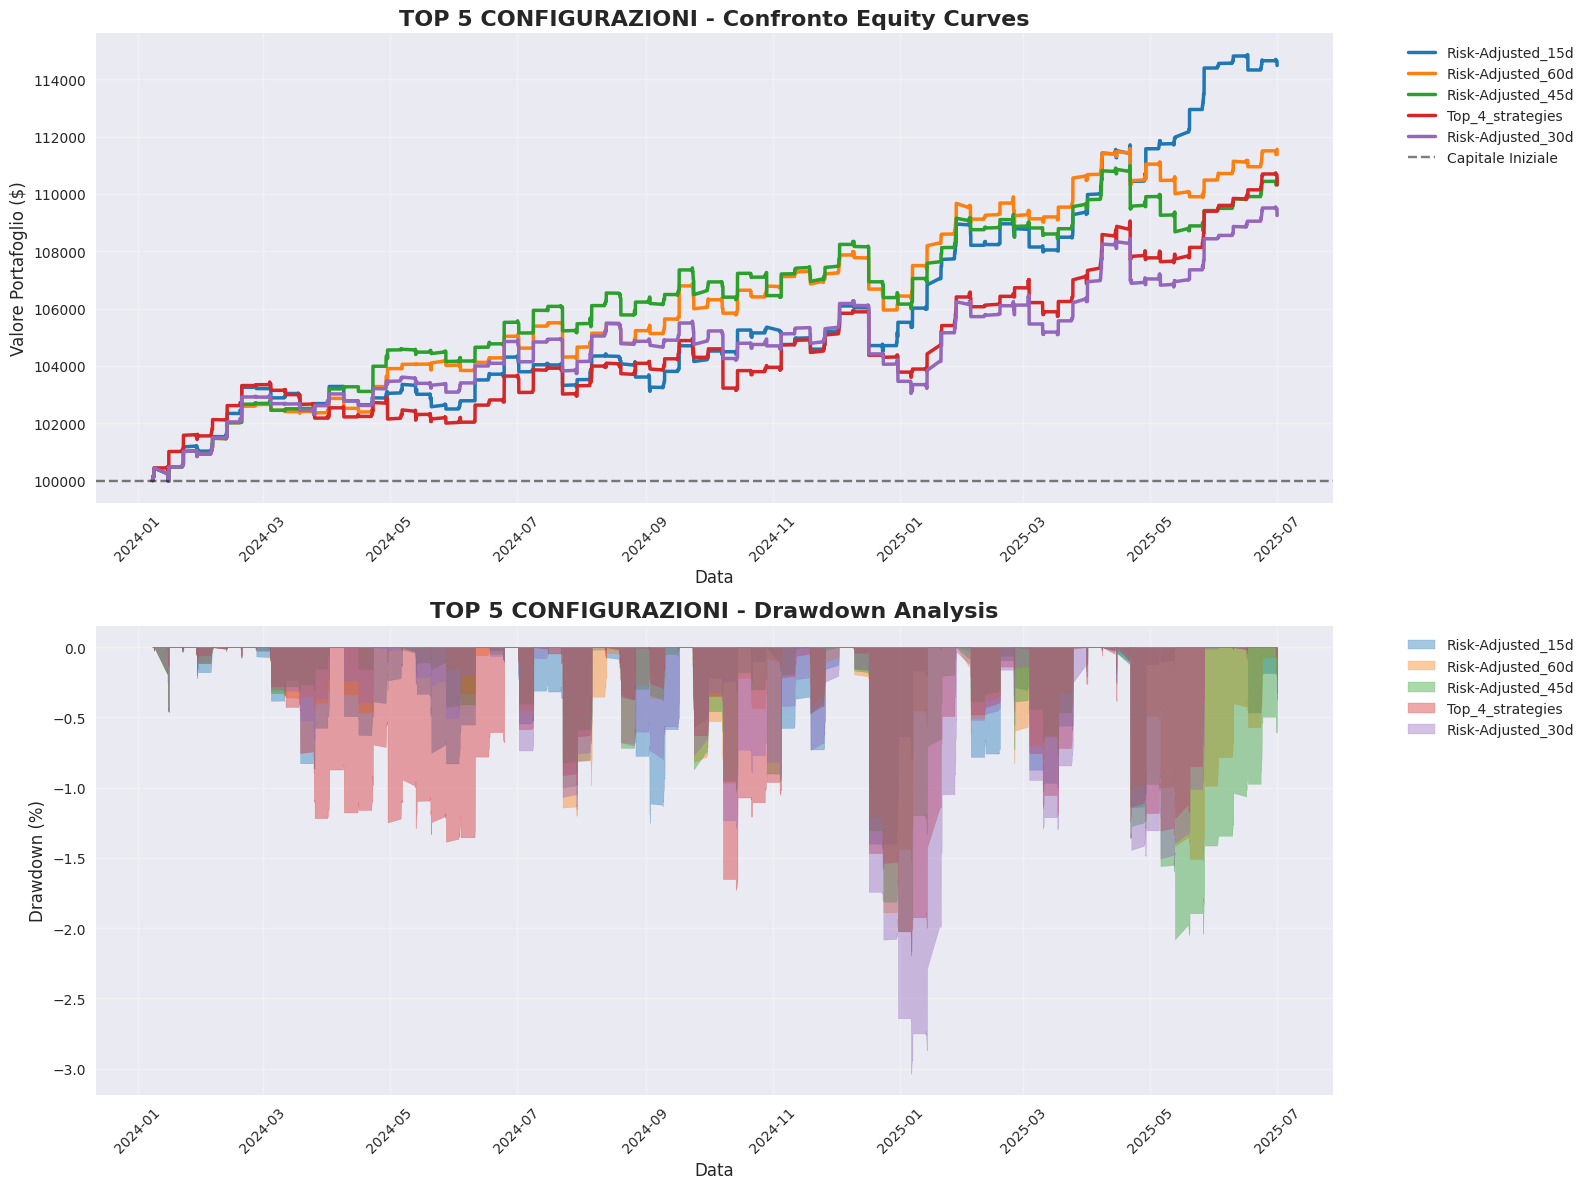


📊 PERFORMANCE FINALI - TOP 5 CONFIGURAZIONI
   Configurazione Valore_Finale_$ Return_Totale_% Sharpe_Ratio Max_Drawdown_% Volatilità_%
Risk-Adjusted_15d        $114,479          14.48%        0.541         -1.58%        0.70%
Risk-Adjusted_60d        $111,555          11.56%        0.463         -1.89%        0.66%
Risk-Adjusted_45d        $110,535          10.54%        0.417         -2.17%        0.67%
 Top_4_strategies        $110,315          10.31%        0.393         -2.20%        0.70%
Risk-Adjusted_30d        $109,243           9.24%        0.348         -3.04%        0.71%

🏆 La configurazione 'Risk-Adjusted_15d' ha mostrato le migliori performance complessive!


In [17]:
# Test di ottimizzazione dei parametri
if 'returns_matrix' in globals() and 'rebalancing_dates' in globals():
    
    print("🔧 OTTIMIZZAZIONE PARAMETRI STRATEGIE")
    print("=" * 50)
    
    optimization_results = {}
    
    # Test diversi lookback window
    lookback_windows = [15, 30, 45, 60]
    
    for lookback in lookback_windows:
        print(f"\n🕒 Testing lookback window: {lookback} giorni")
        
        allocator_opt = MomentumAllocator(returns_matrix, rebalancing_dates, lookback_window=lookback)
        
        # Test strategia risk-adjusted (che sembrava promettente)
        result = backtest_allocation_strategy(
            allocator_opt, 
            'momentum_risk_adjusted', 
            f'Risk-Adjusted (Lookback {lookback}d)'
        )
        
        if result:
            metrics = calculate_performance_metrics(result)
            if metrics:
                optimization_results[f'Risk-Adjusted_{lookback}d'] = metrics
    
    # Test diversi ranking (top N)
    top_n_values = [1, 2, 3, 4]
    
    for top_n in top_n_values:
        print(f"\n🏆 Testing ranking strategy: Top {top_n}")
        
        allocator_rank = MomentumAllocator(returns_matrix, rebalancing_dates, lookback_window=30)
        
        result = backtest_allocation_strategy(
            allocator_rank,
            'momentum_ranking',
            f'Top {top_n} Strategies',
            top_n=top_n
        )
        
        if result:
            metrics = calculate_performance_metrics(result)
            if metrics:
                optimization_results[f'Top_{top_n}_strategies'] = metrics
    
    # Crea DataFrame dei risultati ottimizzazione
    if optimization_results:
        opt_df = pd.DataFrame(optimization_results).T
        opt_df = opt_df.sort_values('sharpe_ratio', ascending=False)
        
        print(f"\n🎯 RISULTATI OTTIMIZZAZIONE (ordinati per Sharpe Ratio)")
        print("=" * 80)
        
        for strategy in opt_df.index:
            metrics = opt_df.loc[strategy]
            print(f"\n📊 {strategy}")
            print(f"   ⚡ Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
            print(f"   📈 Rendimento Annuo: {metrics['annualized_return']:.2f}%")
            print(f"   💥 Max Drawdown: {metrics['max_drawdown']:.2f}%")
            print(f"   🔄 Turnover: {metrics['avg_turnover']:.1f}%")
        
        # Grafico comparativo
        plt.figure(figsize=(15, 10))
        
        # Subplot 1: Sharpe Ratio
        plt.subplot(2, 2, 1)
        opt_df['sharpe_ratio'].plot(kind='bar', color='skyblue')
        plt.title('Sharpe Ratio per Configurazione')
        plt.ylabel('Sharpe Ratio')
        plt.xticks(rotation=45)
        
        # Subplot 2: Rendimento vs Volatilità
        plt.subplot(2, 2, 2)
        plt.scatter(opt_df['volatility'], opt_df['annualized_return'], 
                   s=100, alpha=0.7, c=opt_df['sharpe_ratio'], cmap='viridis')
        plt.xlabel('Volatilità (%)')
        plt.ylabel('Rendimento Annuo (%)')
        plt.title('Risk-Return Profile')
        plt.colorbar(label='Sharpe Ratio')
        
        # Subplot 3: Max Drawdown
        plt.subplot(2, 2, 3)
        opt_df['max_drawdown'].plot(kind='bar', color='salmon')
        plt.title('Maximum Drawdown')
        plt.ylabel('Drawdown (%)')
        plt.xticks(rotation=45)
        
        # Subplot 4: Turnover
        plt.subplot(2, 2, 4)
        opt_df['avg_turnover'].plot(kind='bar', color='orange')
        plt.title('Turnover Medio')
        plt.ylabel('Turnover (%)')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n🏆 CONFIGURAZIONE OTTIMALE: {opt_df.index[0]}")
        print(f"    Sharpe Ratio: {opt_df.iloc[0]['sharpe_ratio']:.3f}")
        print(f"    Rendimento Annuo: {opt_df.iloc[0]['annualized_return']:.2f}%")
        print(f"    Max Drawdown: {opt_df.iloc[0]['max_drawdown']:.2f}%")
        
        # ===== NUOVA SEZIONE: EQUITY CURVES DELLE TOP 5 CONFIGURAZIONI =====
        print(f"\n📈 GENERAZIONE EQUITY CURVES - TOP 5 CONFIGURAZIONI")
        print("=" * 70)
        
        # Seleziona le top 5 configurazioni per Sharpe ratio
        top_5_configs = opt_df.head(5).index.tolist()
        
        # Dizionario per salvare i risultati dei backtest delle top 5
        top_5_backtest_results = {}
        
        # Riesegui i backtest per le top 5 configurazioni
        for config_name in top_5_configs:
            print(f"🔄 Rieseguendo backtest per: {config_name}")
            
            try:
                if config_name.startswith('Risk-Adjusted_'):
                    # ⚠️ CORREZIONE: Parsing più robusto del lookback window
                    # Estrai tutto dopo "Risk-Adjusted_" e rimuovi 'd'
                    lookback_part = config_name.replace('Risk-Adjusted_', '').replace('d', '')
                    lookback = int(lookback_part)
                    
                    allocator_config = MomentumAllocator(returns_matrix, rebalancing_dates, lookback_window=lookback)
                    result = backtest_allocation_strategy(
                        allocator_config, 
                        'momentum_risk_adjusted', 
                        config_name
                    )
                    
                elif config_name.startswith('Top_'):
                    # ⚠️ CORREZIONE: Parsing più robusto del top_n
                    # Cerca il numero tra "Top_" e "_strategies"
                    parts = config_name.split('_')
                    if len(parts) >= 2:
                        top_n = int(parts[1])
                    else:
                        print(f"⚠️ Impossibile parsare top_n da {config_name}, uso default=3")
                        top_n = 3
                    
                    allocator_config = MomentumAllocator(returns_matrix, rebalancing_dates, lookback_window=30)
                    result = backtest_allocation_strategy(
                        allocator_config,
                        'momentum_ranking',
                        config_name,
                        top_n=top_n
                    )
                
                else:
                    print(f"⚠️ Configurazione non riconosciuta: {config_name}")
                    continue
                
                # Salva il risultato se valido
                if result and result['portfolio_returns']:
                    top_5_backtest_results[config_name] = result
                else:
                    print(f"⚠️ Risultato non valido per {config_name}")
                    
            except Exception as e:
                print(f"❌ Errore nel processare {config_name}: {e}")
                continue
        
        # Plot delle equity curves delle top 5 configurazioni
        if top_5_backtest_results:
            plt.figure(figsize=(16, 12))
            
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
            
            # Plot principale - Confronto equity curves
            plt.subplot(2, 1, 1)
            
            equity_data_top5 = {}
            
            for i, (config_name, result) in enumerate(top_5_backtest_results.items()):
                returns = np.array(result['portfolio_returns'])
                equity_curve = np.cumprod(1 + returns) * 100000  # Parte da 100k
                dates = result['rebalancing_dates'][:len(returns)]
                
                equity_data_top5[config_name] = {
                    'equity': equity_curve,
                    'dates': dates,
                    'returns': returns
                }
                
                # Plot della equity curve
                plt.plot(dates, equity_curve, 
                        label=f"{config_name}", 
                        linewidth=2.5, 
                        color=colors[i])
            
            # Linea di riferimento
            plt.axhline(y=100000, color='black', linestyle='--', alpha=0.5, label='Capitale Iniziale')
            
            plt.title('TOP 5 CONFIGURAZIONI - Confronto Equity Curves', fontsize=16, fontweight='bold')
            plt.xlabel('Data', fontsize=12)
            plt.ylabel('Valore Portafoglio ($)', fontsize=12)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            
            # Plot dei drawdown delle top 5
            plt.subplot(2, 1, 2)
            
            for i, (config_name, data) in enumerate(equity_data_top5.items()):
                equity = data['equity']
                running_max = np.maximum.accumulate(equity)
                drawdown = (equity - running_max) / running_max * 100
                
                plt.fill_between(data['dates'], drawdown, 0, alpha=0.4, color=colors[i], label=f"{config_name}")
            
            plt.title('TOP 5 CONFIGURAZIONI - Drawdown Analysis', fontsize=16, fontweight='bold')
            plt.xlabel('Data', fontsize=12)
            plt.ylabel('Drawdown (%)', fontsize=12)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
            # Tabella finale delle performance delle top 5
            print(f"\n📊 PERFORMANCE FINALI - TOP 5 CONFIGURAZIONI")
            print("=" * 90)
            
            final_comparison = []
            for config_name, data in equity_data_top5.items():
                equity = data['equity']
                returns = data['returns']
                
                final_value = equity[-1]
                total_return = (final_value / 100000 - 1) * 100
                
                # Calcola statistiche aggiuntive
                running_max = np.maximum.accumulate(equity)
                drawdown = (equity - running_max) / running_max * 100
                max_dd = drawdown.min()
                
                # Volatilità e Sharpe
                volatility = np.std(returns) * np.sqrt(52) * 100
                sharpe = (np.mean(returns) * 52) / (np.std(returns) * np.sqrt(52)) if np.std(returns) > 0 else 0
                
                final_comparison.append({
                    'Configurazione': config_name,
                    'Valore_Finale_$': f"${final_value:,.0f}",
                    'Return_Totale_%': f"{total_return:.2f}%",
                    'Sharpe_Ratio': f"{sharpe:.3f}",
                    'Max_Drawdown_%': f"{max_dd:.2f}%",
                    'Volatilità_%': f"{volatility:.2f}%"
                })
            
            final_df = pd.DataFrame(final_comparison)
            print(final_df.to_string(index=False))
            
            print(f"\n🏆 La configurazione '{list(equity_data_top5.keys())[0]}' ha mostrato le migliori performance complessive!")
            
        else:
            print("❌ Impossibile generare le equity curves per le top 5 configurazioni!")
        
    else:
        print("❌ Nessun risultato di ottimizzazione!")
        
else:
    print("❌ Dati non disponibili per l'ottimizzazione!")

Certo! Nel tuo notebook, il metodo **risk-adjusted** (`momentum_risk_adjusted`) della classe `MomentumAllocator` assegna i pesi alle strategie **in base allo Sharpe Ratio** calcolato sul periodo di lookback scelto.

### Come funziona il calcolo dei pesi risk-adjusted

1. **Per ogni strategia** viene calcolato lo Sharpe Ratio (annualizzato) usando i rendimenti della finestra di lookback.
2. **I pesi vengono assegnati proporzionalmente** allo Sharpe Ratio, ma solo se è positivo (se è negativo viene considerato zero).
3. **La somma dei pesi è sempre 1** (vengono normalizzati).

#### Esempio pratico (pseudo-codice):

Supponiamo di avere 3 strategie con questi Sharpe Ratio:
- S1: 1.2
- S2: 0.8
- S3: -0.5 (viene portato a 0)

I pesi saranno:
- S1: 1.2 / (1.2 + 0.8 + 0) = 0.6
- S2: 0.8 / (1.2 + 0.8 + 0) = 0.4
- S3: 0 / (1.2 + 0.8 + 0) = 0

#### Estratto di codice dal tuo notebook:


In [ ]:
def momentum_risk_adjusted(self, metrics):
    if metrics is None:
        return {strategy: 1/len(self.strategies) for strategy in self.strategies}

    sharpe_ratios = {strategy: max(0, metrics[strategy]['sharpe_ratio']) for strategy in self.strategies}
    total_sharpe = sum(sharpe_ratios.values())
    if total_sharpe > 0:
        return {strategy: sharpe/total_sharpe for strategy, sharpe in sharpe_ratios.items()}
    else:
        return {strategy: 1/len(self.strategies) for strategy in self.strategies}



**In sintesi:**  
Il peso di ciascuna strategia è proporzionale al suo Sharpe Ratio (se positivo) rispetto alla somma degli Sharpe Ratio di tutte le strategie. Se tutti sono zero o negativi, i pesi sono equi.